In [32]:
%matplotlib inline

import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import median, mean
from pprint import pprint
import sys
from glob import glob

from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from IPython.display import display

CALLERS = ['strelka2', 'vardict', 'mutect2']

CALLER = 'strelka2'
venn_field = 'caller'
#venn_left = 'strelka2'
#venn_right = 'ensemble'
venn_left = 'vardict'
venn_right = 'strelka2'
vl = venn_left
vr = venn_right
l = vl[0]
r = vr[0]

benchmark_d = {
    'mb_100v100': {
        'src_vcf': 'batch1-{c}-annotated.vcf.gz',
        'bench': 'mb',
    },
    'mb_300v50': {
        'src_vcf': 'MB_300vs50-{c}-annotated.vcf.gz',
        'bench': 'mb',
    },
    'colo_40pc_ds': {
        'src_vcf': 'COLO829_40pc_ds-{c}.vcf.gz',
        'bench': 'colo',
    },
    'colo_40pc_full': {
        'src_vcf': 'COLO829_40pc-{c}.vcf.gz',
        'bench': 'colo',
    },
    'colo_tgen': {
        'src_vcf': 'COLO_TGEN_bwa-{c}.vcf.gz',
        'bench': 'colo',
    },
    'colo_hoffman': {
        'src_vcf': 'COLO829_40pc-{c}.vcf.gz',
        'bench': 'colo',
    },
}
for n, d in benchmark_d.items():
    d['name'] = n
    d['df'] = None
    d['eval_dir'] = f'{n}/evalled'
    d['vcf_glob'] = f'{d["eval_dir"]}/anno_gnomad/*{{c}}*/*{{c}}*.vcf.gz'
    d['truth_vcf'] = f'{d["eval_dir"]}/anno_gnomad/truth_variants.vcf.gz'
MinEVS = 6

In [230]:
from ngs_utils.file_utils import add_suffix, file_exists, splitext_plus, intermediate_fname
from os.path import basename, splitext, dirname, join

def _load(n):
    d = benchmark_d[n]
#    print(f'Benchmarking VCFs for {n}')
    vcfs = []
    eval_dir = f'{n}/evalled'
    vcfprep_dir = f'{n}/vcfprep'
    !mkdir -p {vcfprep_dir}
    for c in CALLERS:
        vcf = join(n, d['src_vcf'].format(c=c))
        if file_exists(vcf):
#             vcf_pass = intermediate_fname(vcfprep_dir, vcf, 'pass')
#             if not file_exists(vcf_pass):
#                 cmd = f'bcftools view -f.,PASS {vcf} -Oz -o {vcf_pass} && tabix -p vcf {vcf_pass}'
#                 print(cmd)
#                 !{cmd}
#             vcf_prep = intermediate_fname(vcfprep_dir, vcf, 'prep')
#             if not file_exists(vcf_prep):
#                 cmd = f'pcgr_prep {vcf_pass} | bcftools view -f.,PASS -Oz -o {vcf_prep} && tabix -p vcf {vcf_prep}'
#                 print(cmd)
#                 !{cmd}
#             vcf_pon = intermediate_fname(vcfprep_dir, vcf, 'pon')
#             if not file_exists(vcf_pon):
#                 cmd = f'pon_anno {vcf_prep} -o {vcf_pon} && tabix -p vcf {vcf_pon}'
#                 print(cmd)
#                 !{cmd}
            vcfs.append(vcf)
#             vcf_basename = splitext_plus(basename(vcf_pon))[0]
#             d['isec_dir'] = f'{eval_dir}/eval/{vcf_basename}_bcftools_isec'.replace(c, '{c}')

    if vcfs:
        cmd = f"eval_vcf {d['bench']} {' '.join(vcfs)} -o {eval_dir} --anno-tricky --anno-dp-af --anno-pon --anno-gnomad"
        print(cmd)
        # !{cmd}

#for n, d in benchmark_d.items(): 
_load('mb_100v100')
_load('colo_40pc_ds')
_load('colo_hoffman')
_load('colo_40pc_full')
_load('colo_tgen')
_load('mb_300v50')

eval_vcf mb mb_100v100/batch1-strelka2-annotated.vcf.gz mb_100v100/batch1-ensemble-annotated.vcf.gz mb_100v100/batch1-vardict-annotated.vcf.gz mb_100v100/batch1-mutect2-annotated.vcf.gz -o mb_100v100/evalled --anno-tricky --anno-dp-af --anno-pon --anno-gnomad
eval_vcf colo colo_40pc_ds/COLO829_40pc_ds-strelka2.vcf.gz colo_40pc_ds/COLO829_40pc_ds-ensemble.vcf.gz colo_40pc_ds/COLO829_40pc_ds-vardict.vcf.gz colo_40pc_ds/COLO829_40pc_ds-mutect2.vcf.gz -o colo_40pc_ds/evalled --anno-tricky --anno-dp-af --anno-pon --anno-gnomad
eval_vcf colo colo_hoffman/COLO829_40pc-strelka2.vcf.gz colo_hoffman/COLO829_40pc-ensemble.vcf.gz -o colo_hoffman/evalled --anno-tricky --anno-dp-af --anno-pon --anno-gnomad
eval_vcf colo colo_40pc_full/COLO829_40pc-strelka2.vcf.gz colo_40pc_full/COLO829_40pc-ensemble.vcf.gz colo_40pc_full/COLO829_40pc-vardict.vcf.gz colo_40pc_full/COLO829_40pc-mutect2.vcf.gz -o colo_40pc_full/evalled --anno-tricky --anno-dp-af --anno-pon --anno-gnomad
eval_vcf colo colo_tgen/COLO_TGE

In [33]:
# Parsing VCF for Strelka2, VarDict, and Mutect2 paired somatic calls, loading into DataFrame.
from cyvcf2 import VCF
from collections import defaultdict
from ngs_utils.vcf_utils import get_tumor_sample_id
from ngs_utils.file_utils import add_suffix
import os
from os.path import join
from collections import Counter

def int_to_chrom(val):
    if val == 23: return 'X'
    if val == 24: return 'Y'
    if val == 25: return 'MT'
    if val == 0: return None
    return str(val)
    
def chrom_to_int(chrom):
    if chrom == 'X': return 23
    if chrom == 'Y': return 24
    if chrom == 'MT': return 25
    try:
        return int(chrom)
    except:
        return 0

with open('GRCh37.fa.fai') as f:
    chrom_lens = [(l.split('\t')[0], int(l.split('\t')[1])) for l in f if l.strip()]
    chrom_lens = [(c, l) for c, l in chrom_lens if not c.startswith('GL')]
chrom_positions = [(chrom, sum(l for c, l in chrom_lens if chrom_to_int(c) < chrom_to_int(chrom))) 
                        for chrom, _ in chrom_lens] \
                   + [(None, sum(l for c, l in chrom_lens))]
    
main_sample_index = 0  # get_tumor_sample_id(mm2_vcf)

def rec_to_caller_fields(rec, caller):
    ''' Values different for callers '''
    fields = dict()

    for tag in ['AF', 'DP', 'MQ', 'MQ0']:
        for pheno in ['TUMOR', 'NORMAL']:
            v = rec.INFO.get(f'{pheno}_{tag}')
            if v is not None:
                fields[f'{pheno}_{tag}'] = v

    fields[f'{caller}_QUAL'] = rec.QUAL

    if caller == 'vardict':
        fields[f'NM'] = rec.format('NM')[main_sample_index][0]
        fields[f'vardict_INFO_QUAL'] = rec.format('QUAL')[main_sample_index][0]

    if caller == 'strelka2':
        fields[f'SomaticEVS'] = rec.INFO.get('SomaticEVS')
        fields[f'ReadPosRankSum'] = rec.INFO.get('ReadPosRankSum')
    
    return fields

def rec_to_general_fields(rec):
    ''' Values not specific to caller'''
    fields = dict()
    
    ann = rec.INFO.get('ANN')
    if isinstance(ann, str):  # skip decomposed fields with lost ANN
        fields['gene'] = ann.split('|')[3]

    tricky_anno = rec.INFO.get('TRICKY', '').split(',')
    if 'GIAB_CONF' not in rec.INFO:
        tricky_anno.append('GIAB_NOT_CONF')
    fields['tricky_anno'] = tuple(tricky_anno)

    fields[f'PoN_CNT'] = rec.INFO.get('PoN_CNT', 0)

    fields['is_snp'] = rec.is_snp
    
    if 'gnomAD_AF' in rec.INFO:
        fields['gnomAD_AF'] = rec.INFO['gnomAD_AF']

    return fields

def load_vcfs(bn, types=None, annotate_pon=False, silent=False):
    if not silent: print('Loading for benchmark ' + bn)
    if not silent: print('--------------------------')
    b = benchmark_d[bn]
#    vcfs = defaultdict(dict)
#    vcfs = _get_vcfs(b, types)
    recs_by_loc = defaultdict(dict)
    for caller in CALLERS:
        if not silent: print(f'Parsing VCF for {caller}')
        vcf_glob = glob(b['vcf_glob'].format(c=caller))
        if vcf_glob:
            vcf = vcf_glob[0]
            print(f'  reading {vcf}')
            for rec in VCF(vcf):    
                k = (rec.CHROM, rec.POS, rec.REF, rec.ALT[0])
                recs_by_loc[k][caller] = rec
    for rec in VCF(b['truth_vcf']):    
        k = (rec.CHROM, rec.POS, rec.REF, rec.ALT[0])
        recs_by_loc[k]['truth'] = rec

    print(f'  Analysing data, building dataframe...')
    total = 0
    passed = 0
    rows = []
    for (chrom, pos, ref, alt), d in sorted(recs_by_loc.items(), key=lambda a: a[0]):
        total += 1

        fields = dict(gene='')
        rec = None
        for caller in CALLERS:
            if caller in d:
                c_rec = d[caller]
                fields.update(rec_to_caller_fields(c_rec, caller))
                if rec is None: rec = c_rec
        if rec is None:
            rec = d['truth']
        
        for c in CALLERS + ['truth']:
            fields[f'in_{c}'] = c in d

        fields.update(rec_to_general_fields(rec))

        x = next((p for c, p in chrom_positions if str(c) == str(chrom)), None)
        if x is None: continue  # removing non-standard chromosome
        x += pos
        passed += 1

        row = {
            'chrom_pos': f'{rec.CHROM}:{rec.POS}',
            'label': f'{chrom}:{pos}-{ref}>{alt}', 
            'benchmark': bn,
            'pos': pos,
            'chrom': chrom,
            'x': x,
        }
        row.update(fields)
        assert pos
        rows.append(row)

    if not silent: print(f'Done parsing {total} variants, saved {passed}')
    if not silent: print()

    df = pd.DataFrame(rows).set_index('label', drop=False)
    if types is None:
        b['df'] = df
    return df

load_vcfs('mb_100v100')
load_vcfs('mb_300v50')
load_vcfs('colo_40pc_full')
load_vcfs('colo_40pc_ds')
load_vcfs('colo_tgen')
#load_vcfs('colo_hoffman')
pass

Loading for benchmark mb_100v100
--------------------------
Parsing VCF for strelka2
  reading mb_100v100/evalled/anno_gnomad/batch1-strelka2-annotated/batch1-strelka2-annotated.vcf.gz
Parsing VCF for vardict
  reading mb_100v100/evalled/anno_gnomad/batch1-vardict-annotated/batch1-vardict-annotated.vcf.gz
Parsing VCF for mutect2
  reading mb_100v100/evalled/anno_gnomad/batch1-mutect2-annotated/batch1-mutect2-annotated.vcf.gz
  Analysing data, building dataframe...
Done parsing 109934 variants, saved 109934

Loading for benchmark mb_300v50
--------------------------
Parsing VCF for strelka2
  reading mb_300v50/evalled/anno_gnomad/MB_300vs50-strelka2-annotated/MB_300vs50-strelka2-annotated.vcf.gz
Parsing VCF for vardict
  reading mb_300v50/evalled/anno_gnomad/MB_300vs50-vardict-annotated/MB_300vs50-vardict-annotated.vcf.gz
Parsing VCF for mutect2
  reading mb_300v50/evalled/anno_gnomad/MB_300vs50-mutect2-annotated/MB_300vs50-mutect2-annotated.vcf.gz
  Analysing data, building dataframe..

In [53]:
_df = benchmark_d['mb_100v100']['df']
_df = _df.query('is_snp==True & in_strelka2 == True').sort_values(by=['chrom','pos'])
#     .query('is_snp==True & "ensemble" in callers')
# & "vardict" in callers'
#_df
# print(len(_df.index.tolist()))
# for index, row in _df.iterrows():
#     print(row['label'])

#             '''
#             Here: set properly tp, fp, fn values:
#             If it is in 'truth' caller and current caller, then it's tp, otherwise fp
#             Then iterate over 'truth' caller variants separately and set fn for all those that are not tp
 
#             Double think if we want to set tp/fp/fn here. Maybe better do it when plotting ROC plots?
#             '''
            
#             fields[f'{caller}_typ'] = 'tp'
            
#             if c_typ in ('fp', 'tp') or rec is None and c_rec is not None:
#                 rec = c_rec


# RoC

In [142]:
# Defining function for plotting ROC and TP/FP ratios curves
from matplotlib import gridspec
from itertools import combinations

F_MEASURE = 2

COLORS_BY_CALLER = {
    'strelka2': ['red', 'pink'],
    'vardict':  ['blue', 'lightskyblue'],
    'mutect2':  ['green', 'lightgreen'],
    'ensemble': ['gold', 'lightgoldenrodyellow'], 
}

PLOT_ENSEMBLE = True

def in_clr(v, clr):
    return v.get(f'in_{clr}', False) is True

def only_clr(v, clr):
    if in_clr(v, clr):
        for c in callers:
            if c != clr and in_clr(v, c):
                return False
        return True
    return False

def f_measure(b, prec, recall):
    return (1 + b**2) * prec * recall / (b**2 * prec + recall) if prec + recall > 0 else 0.

def _plot(df, field, tpfp_ax, fm_ax, clrs, start, end, step, label_step, show_values, 
          get_qry=None, get_filt_qry=None):
    tps_by_clr, fns_by_clr, fps_by_clr, fms_by_clr =\
        defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
    max_fm_by_clr = dict()
    
    real_mask = df['in_truth'] == True
    
#     if filt_fn is None:
#         filt_fn = lambda v, c: True
#     if field_fn is None:
#         field_fn = lambda v, val, c: v[field] >= val
    vals = np.arange(start, end + step, step)
    
    for val in vals:
        qry_by_clr = dict()
        def _get_clr_qry(c, get_filt_qry=None):
            qry = get_qry(c).format(val=val) if get_qry is not None else f'{field} >= {val}'
            clr_qry = f'in_{c} & ({qry})'
            if get_filt_qry is not None:
                if not isinstance(get_filt_qry, list):
                    get_filt_qry = [get_filt_qry]
                get_filt_qry = [gfq for gfq in get_filt_qry if gfq(c)]
                if get_filt_qry:
                    clr_qry += ' & ' + ' & '.join(gfq(c) for gfq in get_filt_qry)
            return clr_qry            
        for c in clrs:
            qry_by_clr[c] = _get_clr_qry(c, get_filt_qry)
        if PLOT_ENSEMBLE:
            qry = ' | '.join(f'({qry_by_clr[c1]}) & ({qry_by_clr[c2]})' for c1, c2 in combinations(clrs, 2))
            qry_by_clr['ensemble'] = qry

        for c, qry in qry_by_clr.items():
            tp_df = df.query(f'in_truth     & ({qry})')
            fp_df = df.query(f'not in_truth & ({qry})')
            fn_df = df.query(f'in_truth & not ({qry})')

            tp = len(tp_df)
            fp = len(fp_df)
            fn = len(fn_df)
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0

            tps_by_clr[c].append(tp)
            fps_by_clr[c].append(fp)
            fns_by_clr[c].append(fn)

            fm = f_measure(F_MEASURE, prec, recall)
            fms_by_clr[c].append(fm)
            if c not in max_fm_by_clr or fm > max_fm_by_clr[c][0]:
                max_fm_by_clr[c] = fm, val

    for clr in clrs + (['ensemble'] if PLOT_ENSEMBLE else []):
        # TP and FP plots
        tpfp_ax.plot(vals, tps_by_clr[clr], '-', c=COLORS_BY_CALLER[clr][0], lw=0.5)
        tpfp_ax.plot(vals, tps_by_clr[clr], '.', c=COLORS_BY_CALLER[clr][0], label=f'{clr} TPs')
        tpfp_ax.plot(vals, fps_by_clr[clr], '-', c=COLORS_BY_CALLER[clr][1], lw=0.5)
        tpfp_ax.plot(vals, fps_by_clr[clr], '.', c=COLORS_BY_CALLER[clr][1], label=f'{clr} FPs')
        tpfp_ax.plot(vals, fns_by_clr[clr], '-', c=COLORS_BY_CALLER[clr][1], lw=0.5)
        tpfp_ax.plot(vals, fns_by_clr[clr], 'x', c=COLORS_BY_CALLER[clr][1], label=f'{clr} FNs')

        # F measure
        fms = fms_by_clr[clr]
        fm_ax.plot(vals, fms, '-', c=COLORS_BY_CALLER[clr][0], lw=0.5)
        fm_ax.plot(vals, fms, '.', c=COLORS_BY_CALLER[clr][0], label=f'{clr} F{F_MEASURE}')

    max_tp = max(max(vs) for vs in tps_by_clr.values())
    max_fp = max(max(vs) for vs in fps_by_clr.values())
    max_calls = max(max_tp, max_fp)
    calls_range = max_calls
    calls_delta = calls_range*0.03

    vals_range = end-start
    vals_delta = vals_range*0.03

    # Plot labels
    annotated_xy = []
    annotated_tpfp = []
    annotated_mv = []
    for clr in clrs + (['ensemble'] if PLOT_ENSEMBLE else []):
        for v, tp, fp, fm, fm in zip(vals, tps_by_clr[clr], fps_by_clr[clr], fns_by_clr[clr], fms_by_clr[clr]):
            label = f'{v:.3}' if isinstance(v, float) else f'{v}'
            if v % label_step == 0:
                if not any(abs(x - v) < vals_delta and abs(y - tp) < calls_delta for x, y in annotated_xy):
                    tpfp_ax.annotate(f'{label}: {tp}', xy=(v+vals_range*0.005, tp+calls_range*0.005))
                    annotated_xy.append((v, tp))
                if not any(abs(x - v) < vals_delta and abs(y - fp) < calls_delta for x, y in annotated_xy):
                    tpfp_ax.annotate(f'{label}: {fp}', xy=(v+vals_range*0.005, fp+calls_range*0.005))
                    annotated_xy.append((v, fp))
                if not any(abs(x - v) < vals_delta and abs(y - fn) < calls_delta for x, y in annotated_xy):
                    tpfp_ax.annotate(f'{label}: {fn}', xy=(v+vals_range*0.005, fn+calls_range*0.005))
                    annotated_xy.append((v, fn))

        mv, v = max_fm_by_clr[clr]
        label = f'{v:.3}' if isinstance(v, float) else f'{v}'
        if not any(abs(x - v) < vals_delta and abs(y - mv) < 0.05 for x, y in annotated_mv):
            fm_ax.annotate(f'{label}: {mv:.3} (max F{F_MEASURE} for {clr})', xy=(v+vals_range*0.005, mv+0.005))
            annotated_mv.append((v, mv))

    tpfp_ax.set_xlim([start-vals_delta, end+vals_delta])
    tpfp_ax.set_ylim([-calls_delta, max_calls+calls_delta])

    fm_ax.set_xlim([start-vals_delta, end+vals_delta])
    fm_ax.set_ylim([0, 1])

    #roc_ax.legend(*roc_ax.get_legend_handles_labels(), loc='best')  #'upper left')
    tpfp_ax.legend(*tpfp_ax.get_legend_handles_labels(), loc='best') #loc='center right', bbox_to_anchor=(1.21, 0.5))
    #tpfp_ax.legend(*tpfp_ax.get_legend_handles_labels(), loc=tpfp_legend or 'lower left')
    fm_ax.legend(*fm_ax.get_legend_handles_labels(), loc='best')  #, loc='lower left')

def plot_roc(bn, field, start, end, step=1, label_step=5, show_values=True, 
             get_qry=None, get_filt_qry=None, df=None, only_callers=[], skip_callers=[]):
    b = benchmark_d[bn]
    df = df if (df is not None) else benchmark_d[bn]['df']
    assert df is not None
    
    # PLOTTING
    print(f'Plotting {bn}')
    fig = plt.figure(figsize=(20, 20))
    grid = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

    clrs = only_callers or [c for c in CALLERS if c not in skip_callers]
    
    print(f'  SNPs...')
    tpfp_ax = plt.subplot(grid[0], title=f'{bn} snps by {field}')  
    plt.grid()
    tpfp_ax.set_xlabel(field)
    tpfp_ax.set_ylabel('SNPs')
    fm_ax = plt.subplot(grid[2], title=f'{bn} snps F{F_MEASURE} by {field}')
    plt.grid()
    fm_ax.set_xlabel(field)
    fm_ax.set_ylabel('Fx')
    _plot(df[df['is_snp'] == True], field, tpfp_ax, fm_ax, clrs, start, end, step, 
          label_step, show_values, get_qry, get_filt_qry)
    
    print(f'  indels...')
    tpfp_ax = plt.subplot(grid[1], title=f'{bn} indels by {field}')  
    plt.grid()
    tpfp_ax.set_xlabel(field)
    tpfp_ax.set_ylabel('Indels')
    fm_ax = plt.subplot(grid[3], title=f'{bn} indels F{F_MEASURE} by {field}')
    plt.grid()
    fm_ax.set_xlabel(field)
    fm_ax.set_ylabel('Fx')
    _plot(df[df['is_snp'] != True], field, tpfp_ax, fm_ax, clrs, start, end, step, 
          label_step, show_values, get_qry, get_filt_qry)

def q_af(c):
    if c == 'vardict':
        return '(vardict_INFO_QUAL * TUMOR_AF) >= {val}'
    else:
        return 'TUMOR_AF >= 0'

def vd_filt_af(c):  # VarDict is getting better than strelka after this filtering!
    if c == 'vardict':
        return '(vardict_INFO_QUAL * TUMOR_AF) >= 0.3*36'

# plot_roc('mb_100v100', 'vdQ*AF', start=0, end=41, step=1, label_step=4, get_qry=q_af,
#          get_filt_qry=vd_filt)
# plot_roc('mb_100v100', 'vdQ*AF', start=0, end=41, step=1, label_step=4, get_qry=q_af,
#          get_filt_qry=vd_filt_af)
# plot_roc('mb_100v100', 'vardict_INFO_QUAL', start=25, end=41, step=1, label_step=5, get_filt_qry=vd_filt)
# plot_roc('mb_100v100', 'vardict_INFO_QUAL', start=25, end=41, step=1, label_step=5, get_filt_qry=vd_filt_af)

#plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02,
#         get_filt_qry=vd_filt)
#plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02,
#         get_filt_qry=vd_filt_af)
pass

Plotting mb_100v100
  SNPs...
  indels...
Plotting colo_40pc_ds
  SNPs...
  indels...


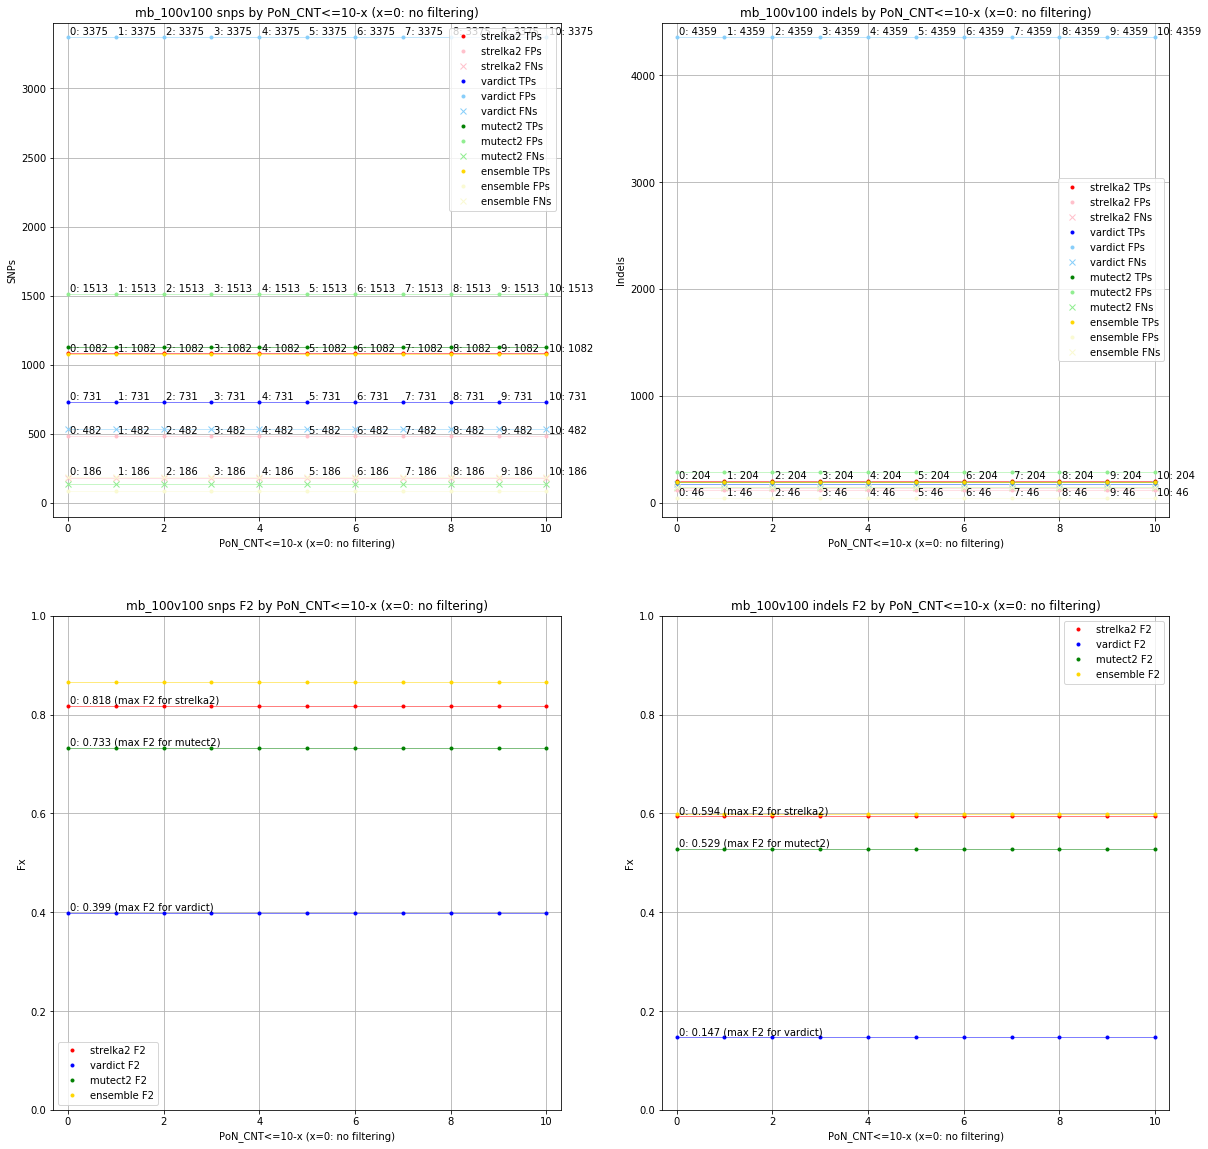

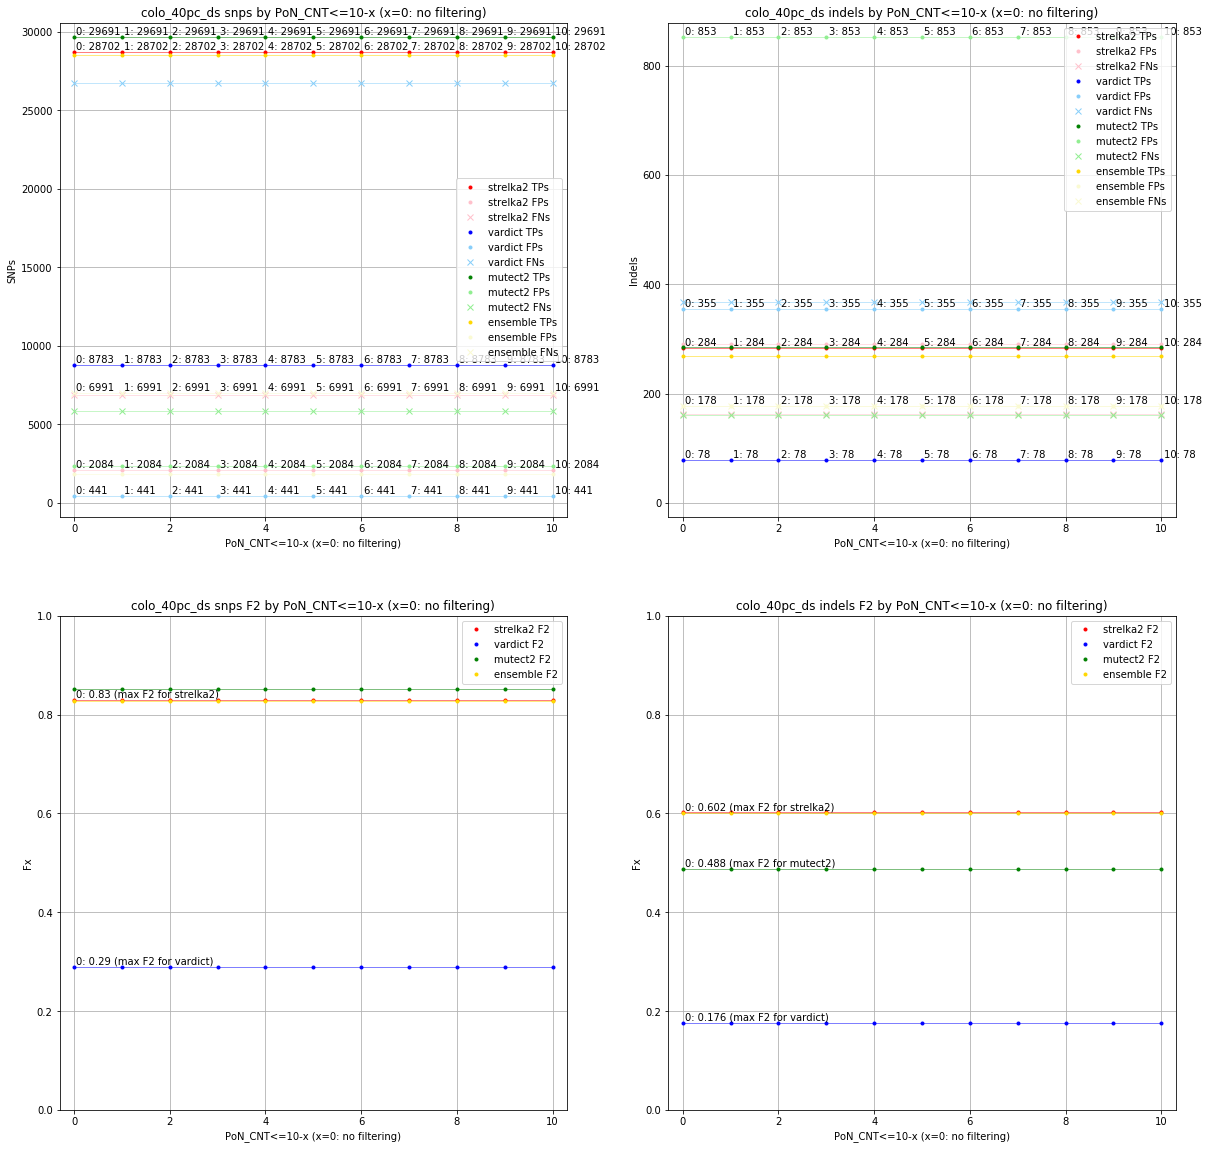

In [143]:
MAX_PON=10
def get_pon(c):
    return f'{MAX_PON}-PoN_CNT >= ' + '{val}'
    
def pon_filt(c):
    return f'{MAX_PON}-PoN_CNT >= {MAX_PON}'

# def get_pon(v):
#     pon_cnt = v['PoN_CNT']
#     if np.isnan(pon_cnt): pon_cnt = math.inf

#     pon_level = MAX_PON  # we want pon_level be the-more-the-better
#     for n in range(MAX_PON):
#         if pon_cnt == n:  # PoN_CNT=0 is the best quality, so it translates into the highest value MAX_PON-0
#             return MAX_PON-n
#     return 0  # if PoN_CNT is as high as MAX_PON, we always return the lowest value 0

plot_roc('mb_100v100', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, 
    step=1, label_step=1, get_filt_qry=[vd_filt_af, pon_filt], get_qry=get_pon)
plot_roc('colo_40pc_ds', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, 
    step=1, label_step=1, get_filt_qry=[vd_filt_af, pon_filt], get_qry=get_pon)

#plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02,
#         get_filt_qry=vd_filt)
#plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02,
#         get_filt_qry=vd_filt_af)
pass

Plotting mb_100v100


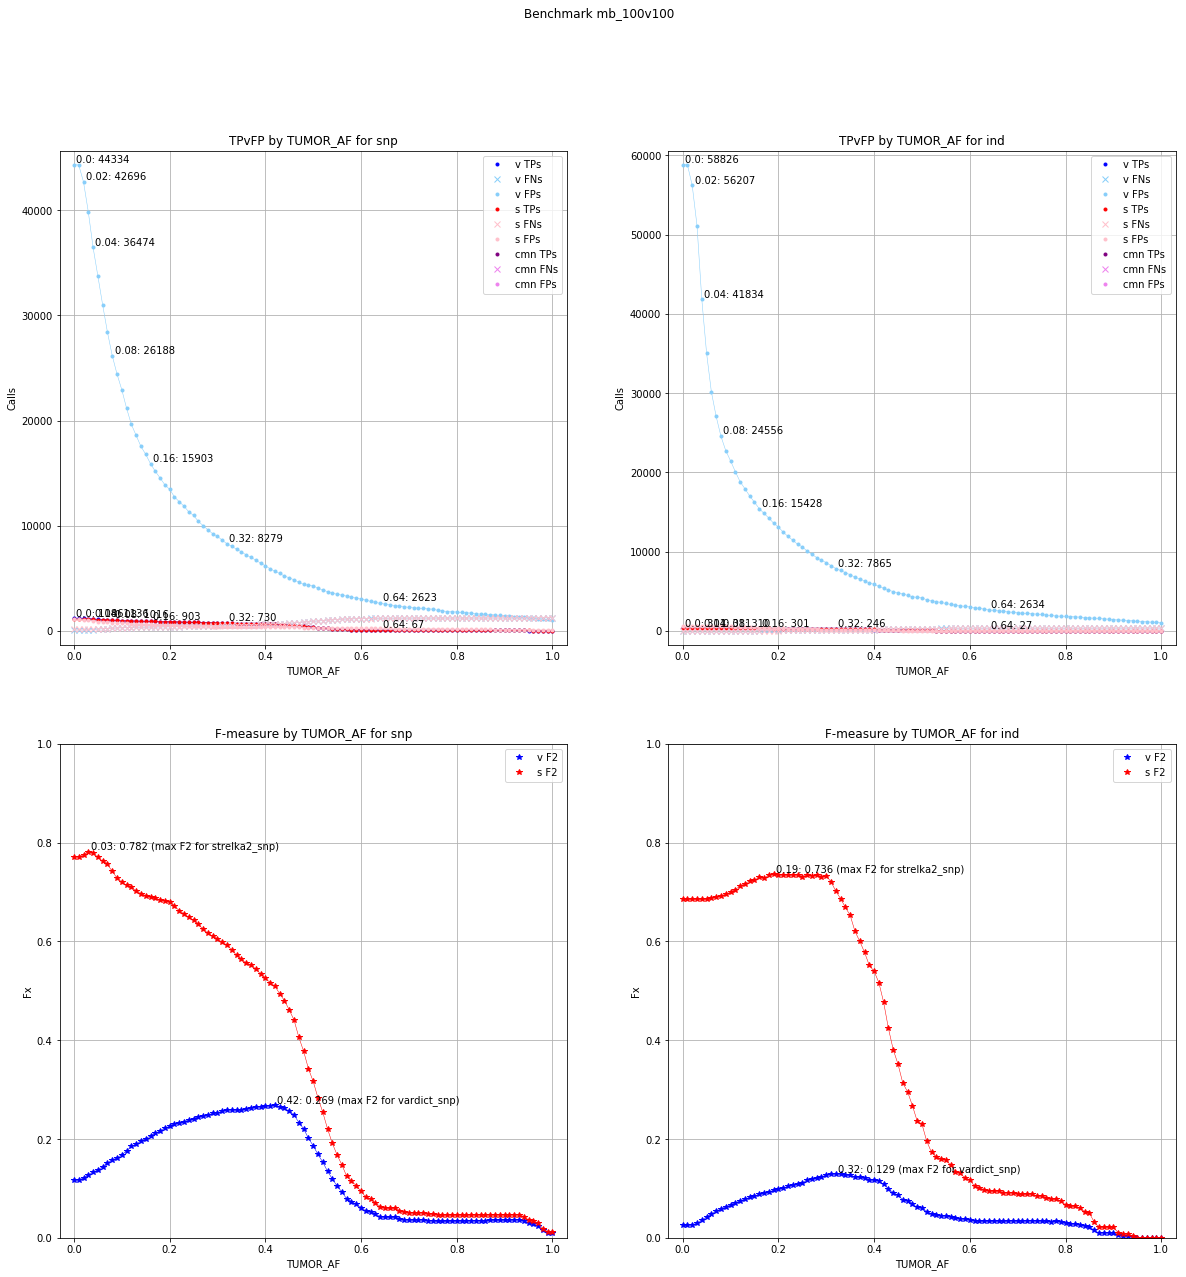

In [191]:
plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02)

Plotting mb_100v100


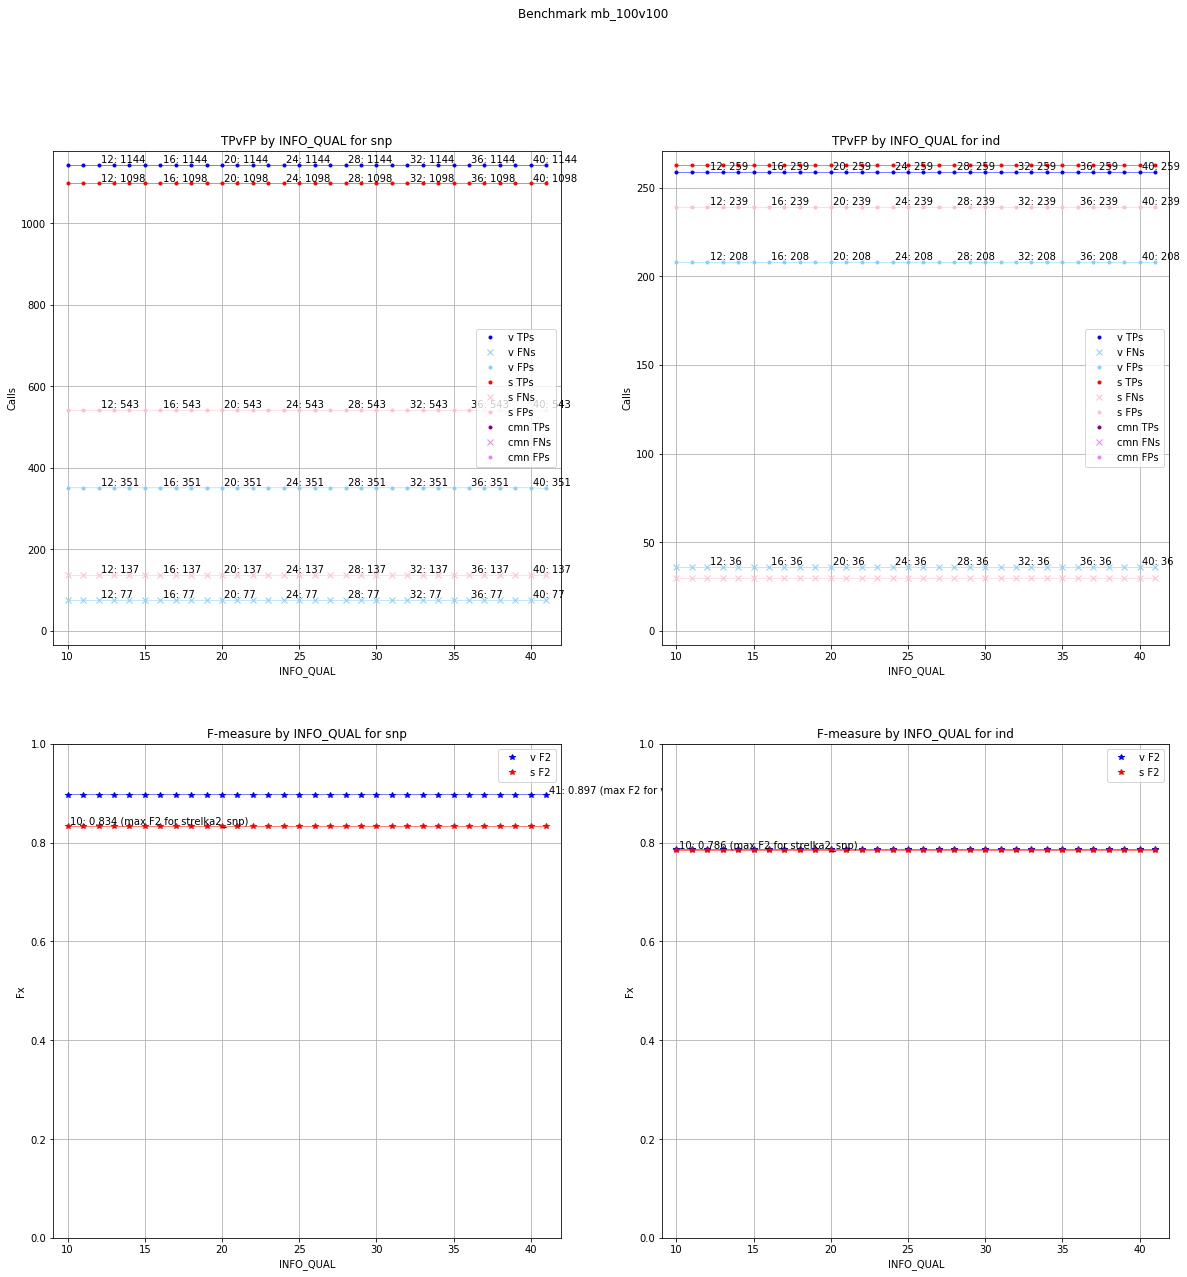

In [189]:
def get_evs(v):
    evs = v['SomaticEVS']
    if np.isnan(evs): evs = 20
    return evs
    
def field_fn(v):
    return get_vd_af_qual(v)

def filt(v):  # VarDict is getting better than strelka after this filtering!
    if is_clr(v, 'vardict'):
        return get_pon(v) < MAX_PON or get_vd_af_qual(v) < 40
    return get_pon(v) < 4 if v['is_snp'] else get_pon(v) < 1

#plot_roc('mb_100v100', 'vardict_INFO_QUAL', start=0, end=41, step=1, label_step=5, field_fn=get_vd_af_qual)
plot_roc('mb_100v100', 'INFO_QUAL', start=10, end=41, step=1, label_step=4, field_fn=field_fn, filt_fn=filt)
# plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02)
# plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02, filt_fn=filt_fn)
pass

Plotting colo_40pc_ds


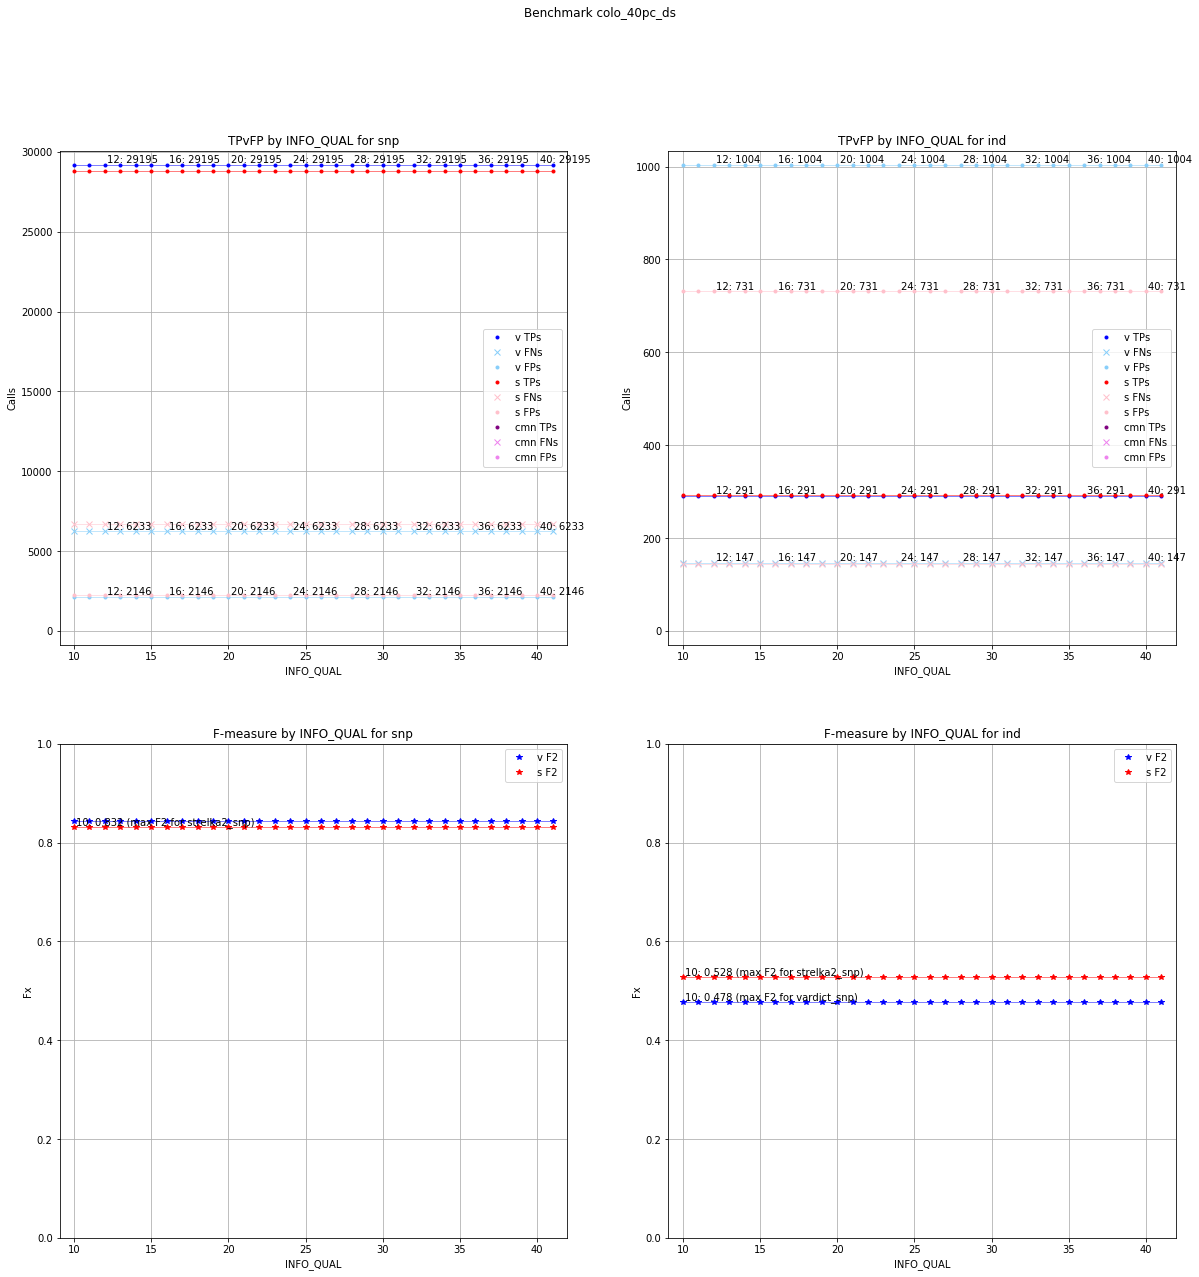

In [193]:
def filt(v):  # VarDict is getting better than strelka after this filtering!
    if is_clr(v, 'vardict'):
        return get_pon(v) < MAX_PON or get_vd_af_qual(v) < 40
    return get_pon(v) < 4 if v['is_snp'] else get_pon(v) < 1

plot_roc('colo_40pc_ds', 'INFO_QUAL', start=10, end=41, step=1, label_step=4, field_fn=field_fn, filt_fn=filt)

Plotting mb


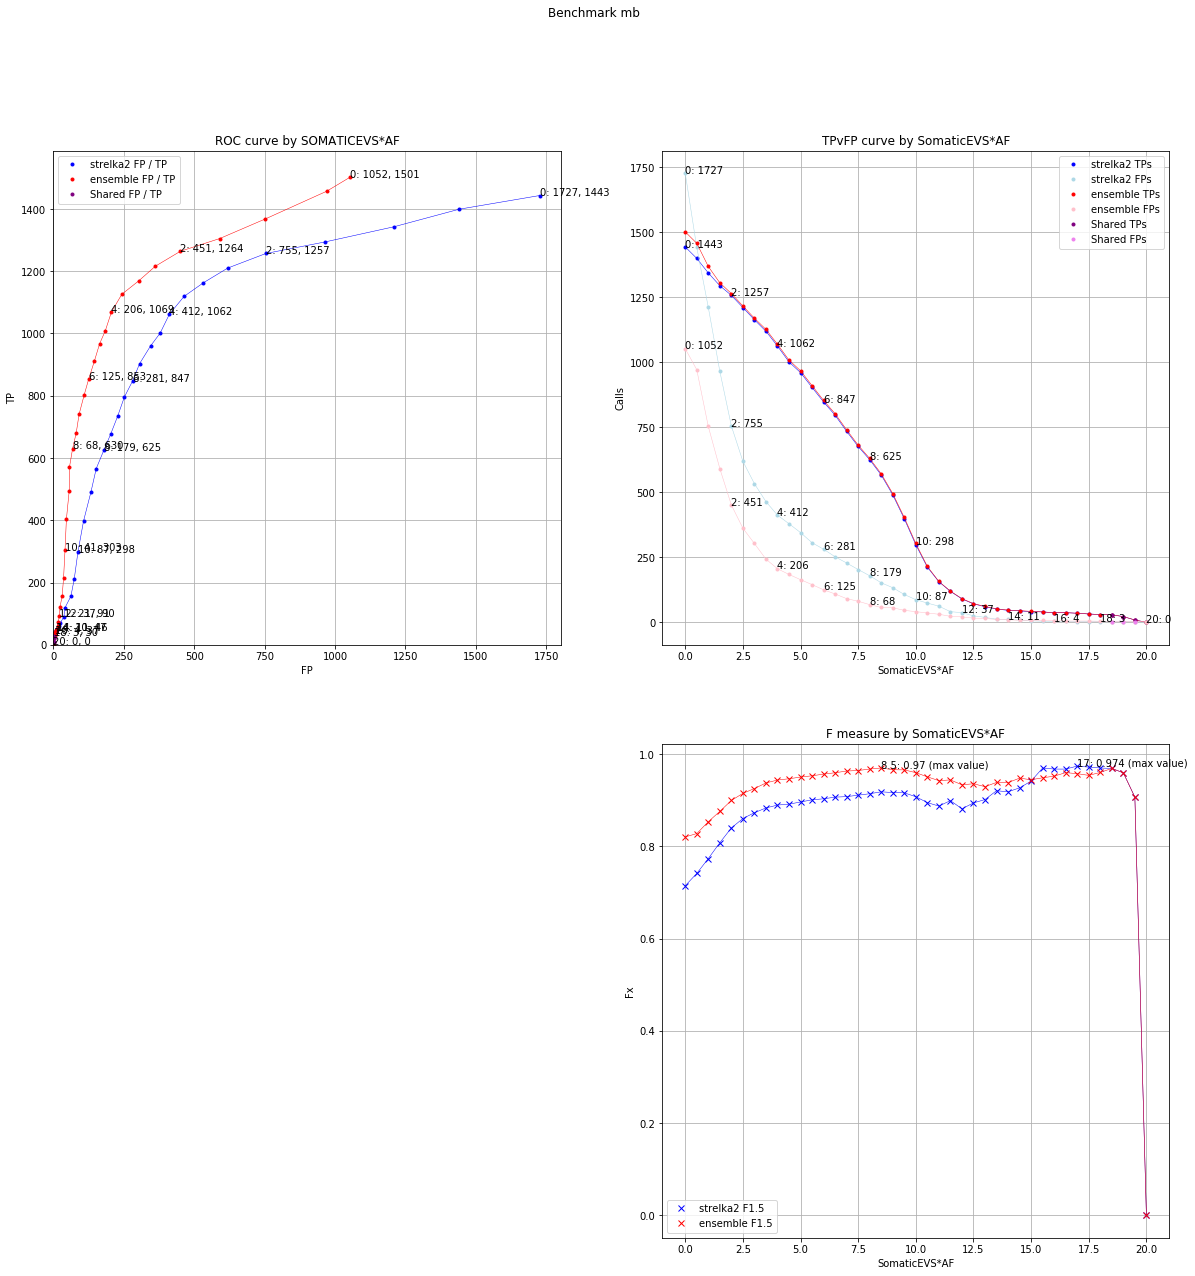

In [257]:
def get_evs_af(v):
    evs = v['SomaticEVS']
    if np.isnan(evs): evs = 20
    #evs = evs/20  # normalise
    taf = v['TUMOR_AF']
    return evs * taf

plot_roc('mb_100v100', 'SomaticEVS*AF', start=.0, end=20., step=0.5, label_step=2., field_fn=get_evs_af)
pass

/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Plotting mb_100v100


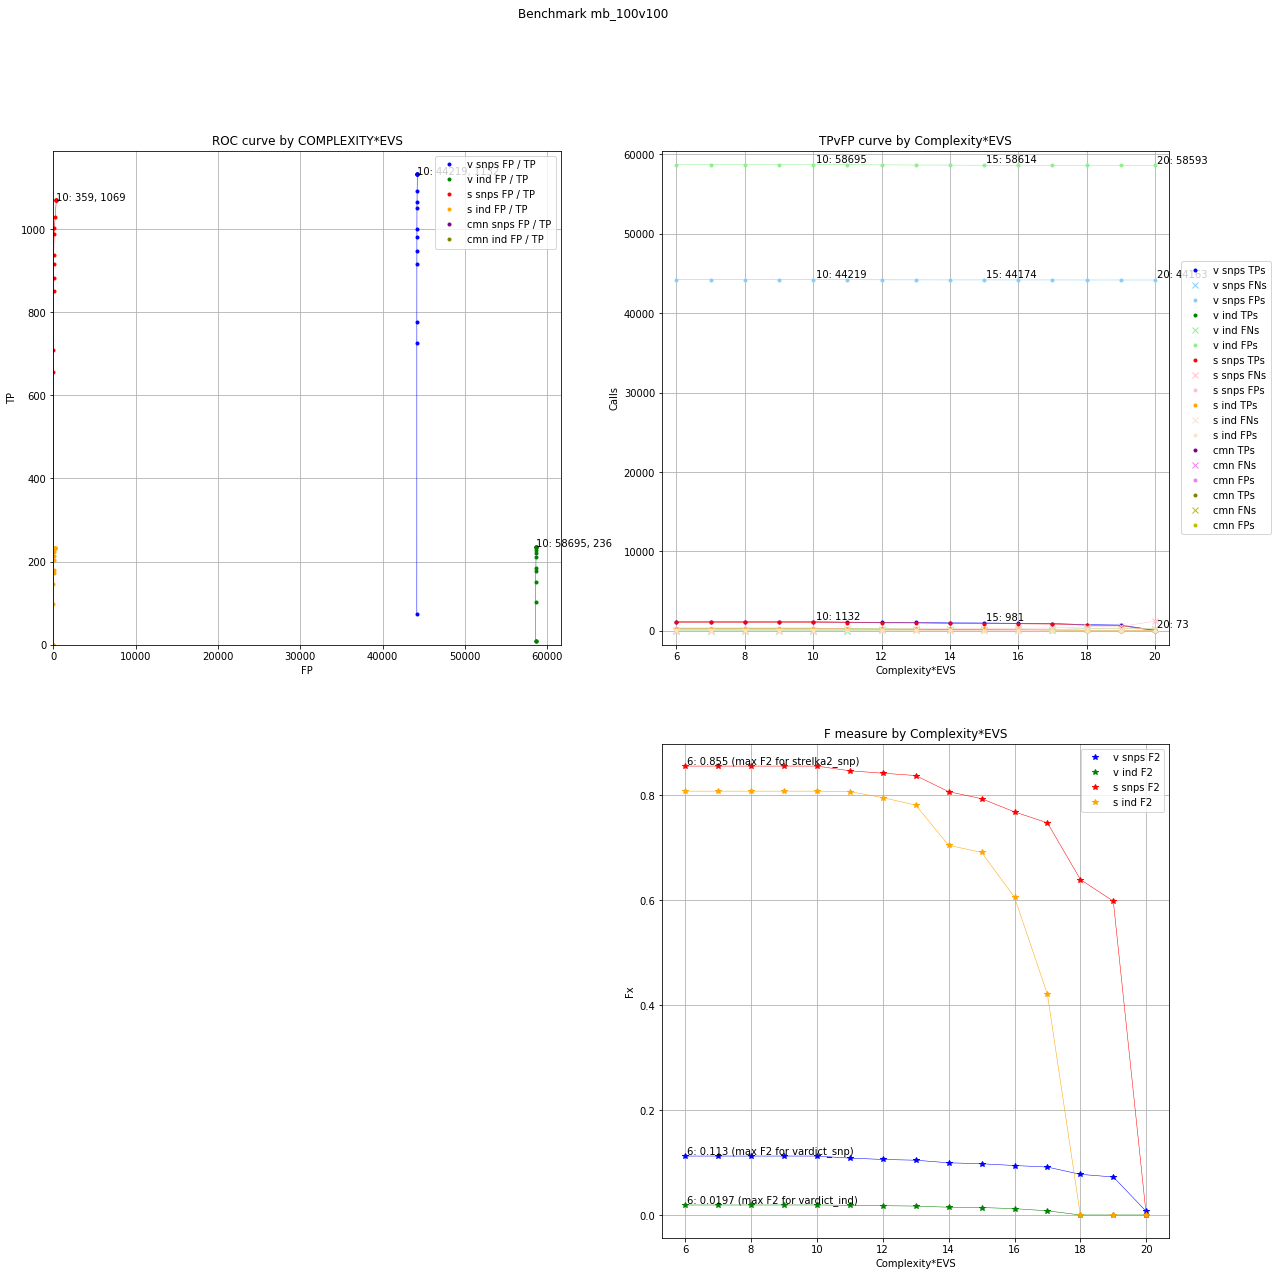

In [92]:
def get_cmpl(v):
    tas = v['tricky_anno']
    cmpl = 2
    if all(ta in ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']
           for ta in tas):
        cmpl = 1
    elif tas:
        cmpl = 0
    return cmpl
   
def filt_fn(v):
    cmpl = get_cmpl(v)
    evs = get_evs(v)
    return cmpl == 2 and evs > 6 or cmpl == 1 and evs > 8 or cmpl == 0 and evs > 10

#plot_roc('mb', 'Complexity', start=0, end=2, step=1, label_step=1, show_values=True, field_fn=get_cmpl)
plot_roc('mb_100v100', 'Complexity*EVS', start=6, end=20, step=1, label_step=5, field_fn=get_evs, filt_fn=filt_fn)
pass

/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Plotting mb_ds


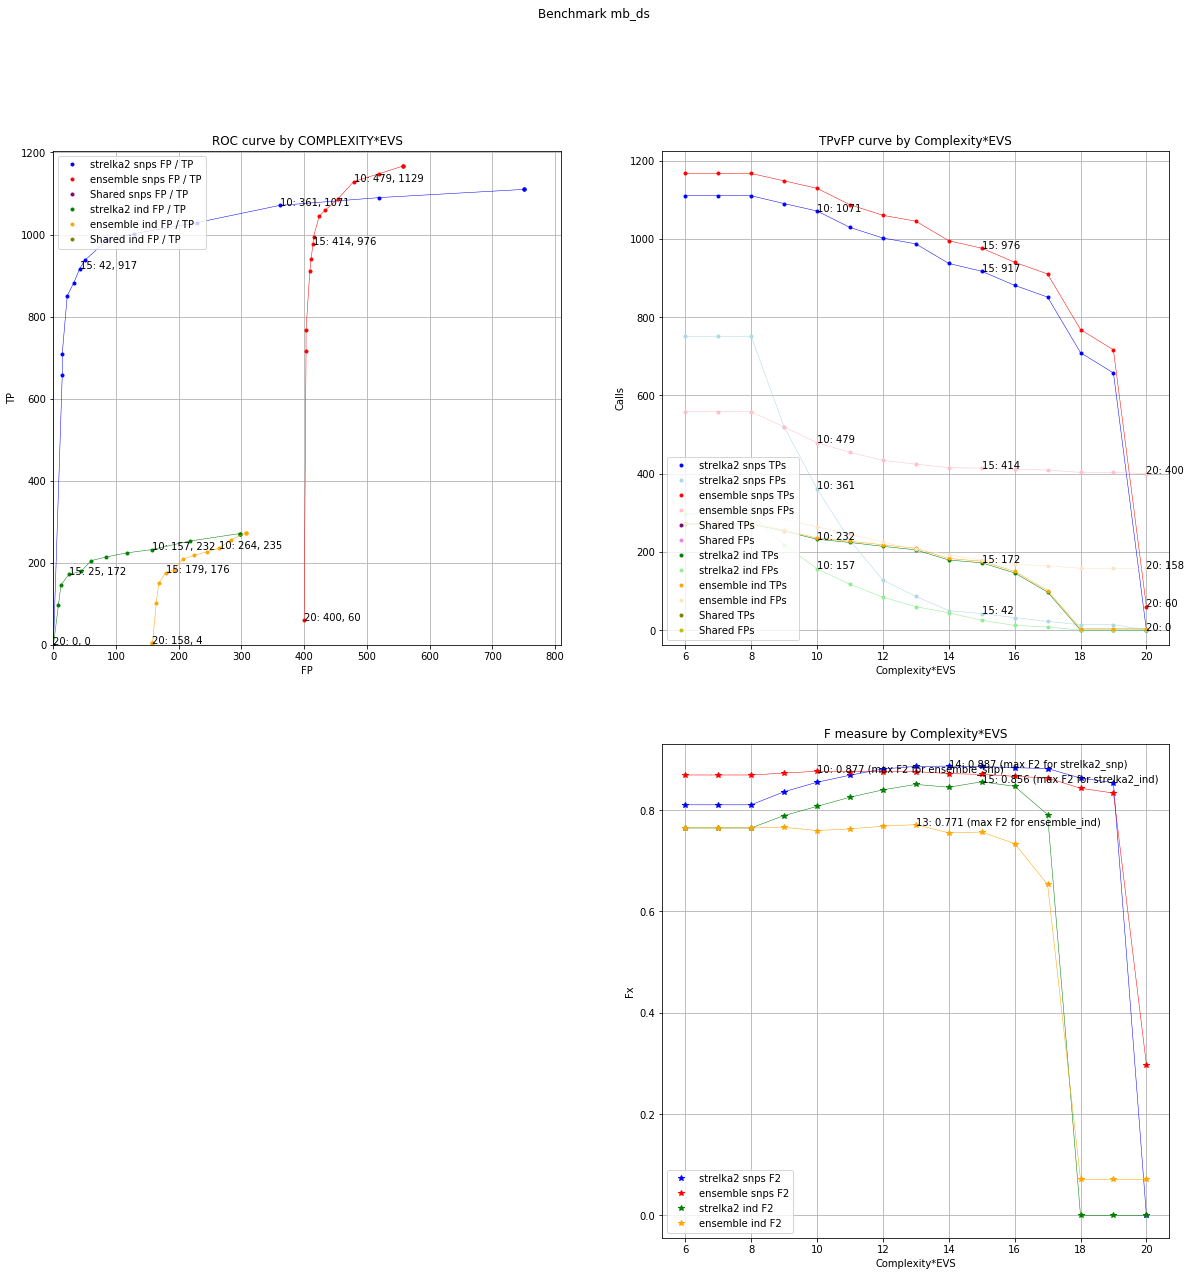

In [398]:
def get_cmpl(v):
    tas = v['tricky_anno']
    cmpl = 2
    if all(ta in ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']
           for ta in tas):
        cmpl = 1
    elif tas:
        cmpl = 0
    return cmpl
   
def filt_fn(v):
    cmpl = get_cmpl(v)
    evs = get_evs(v)
    return  evs > 8

#plot_roc('mb', 'Complexity', start=0, end=2, step=1, label_step=1, show_values=True, field_fn=get_cmpl)
plot_roc('mb_100v100', 'Complexity*EVS', start=6, end=20, step=1, label_step=5, field_fn=get_evs, filt_fn=filt_fn)
pass

/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Plotting mb_ds


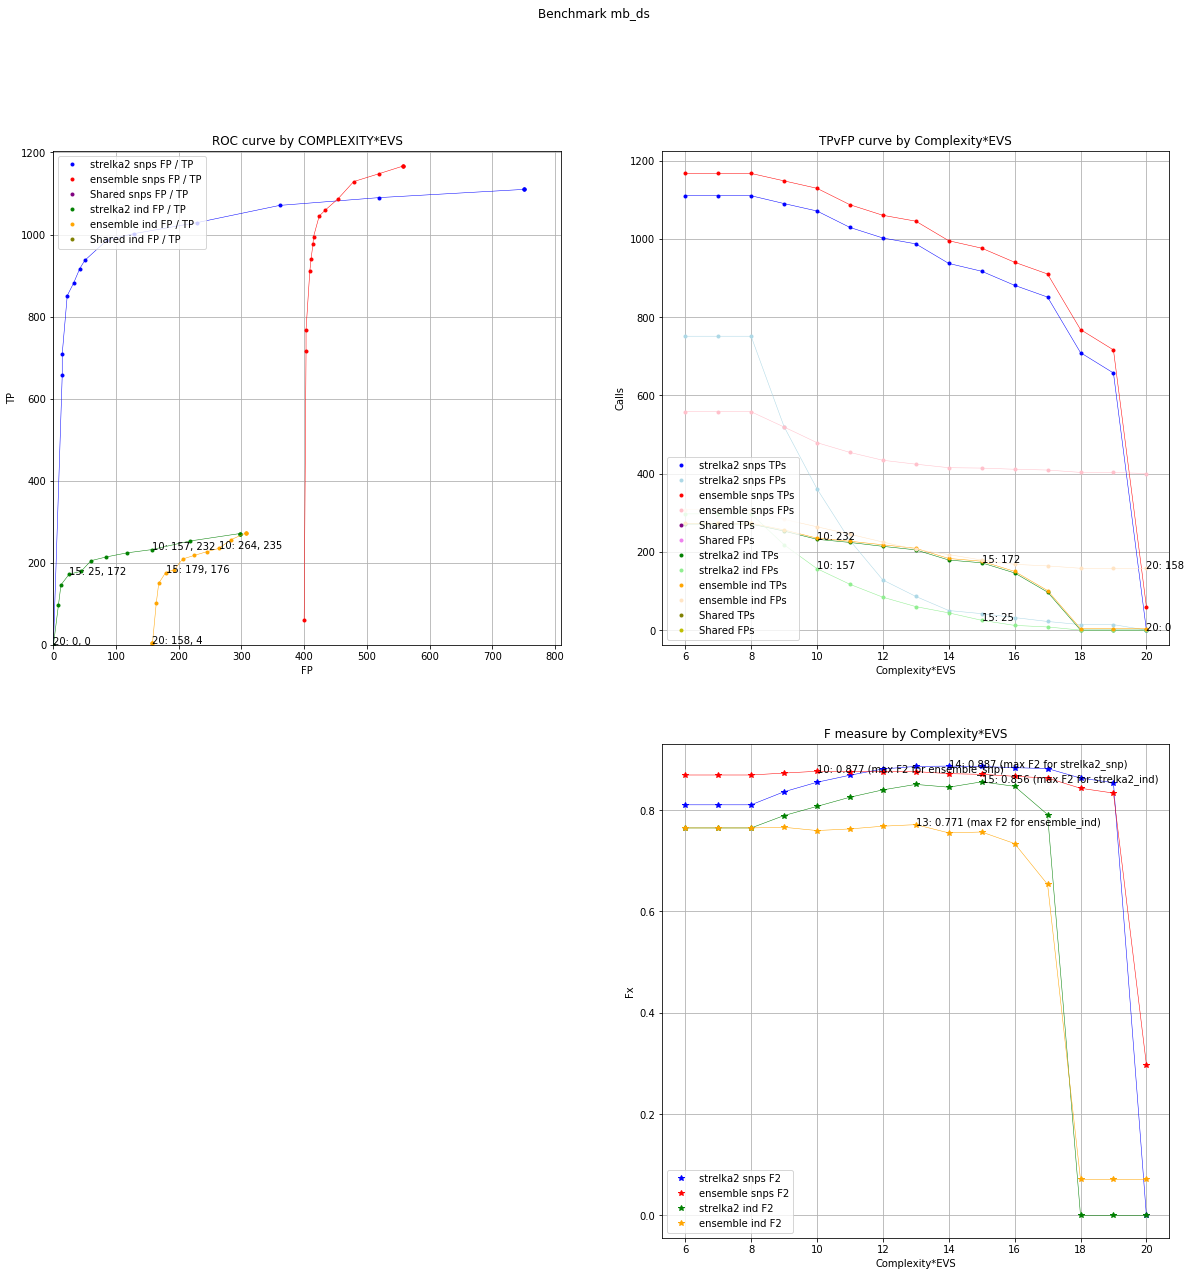

In [391]:
def get_cmpl(v):
    tas = v['tricky_anno']
    cmpl = 2
    if all(ta in ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']
           for ta in tas):
        cmpl = 1
    elif tas:
        cmpl = 0
    return cmpl
   
def filt_fn(v):
    cmpl = get_cmpl(v)
    evs = get_evs(v)
    return  evs > 8

#plot_roc('mb', 'Complexity', start=0, end=2, step=1, label_step=1, show_values=True, field_fn=get_cmpl)
plot_roc('mb_100v100', 'Complexity*EVS', start=6, end=20, step=1, label_step=5, field_fn=get_evs, filt_fn=filt_fn)
pass

Plotting mb_100v100
Plotting mb_300v50


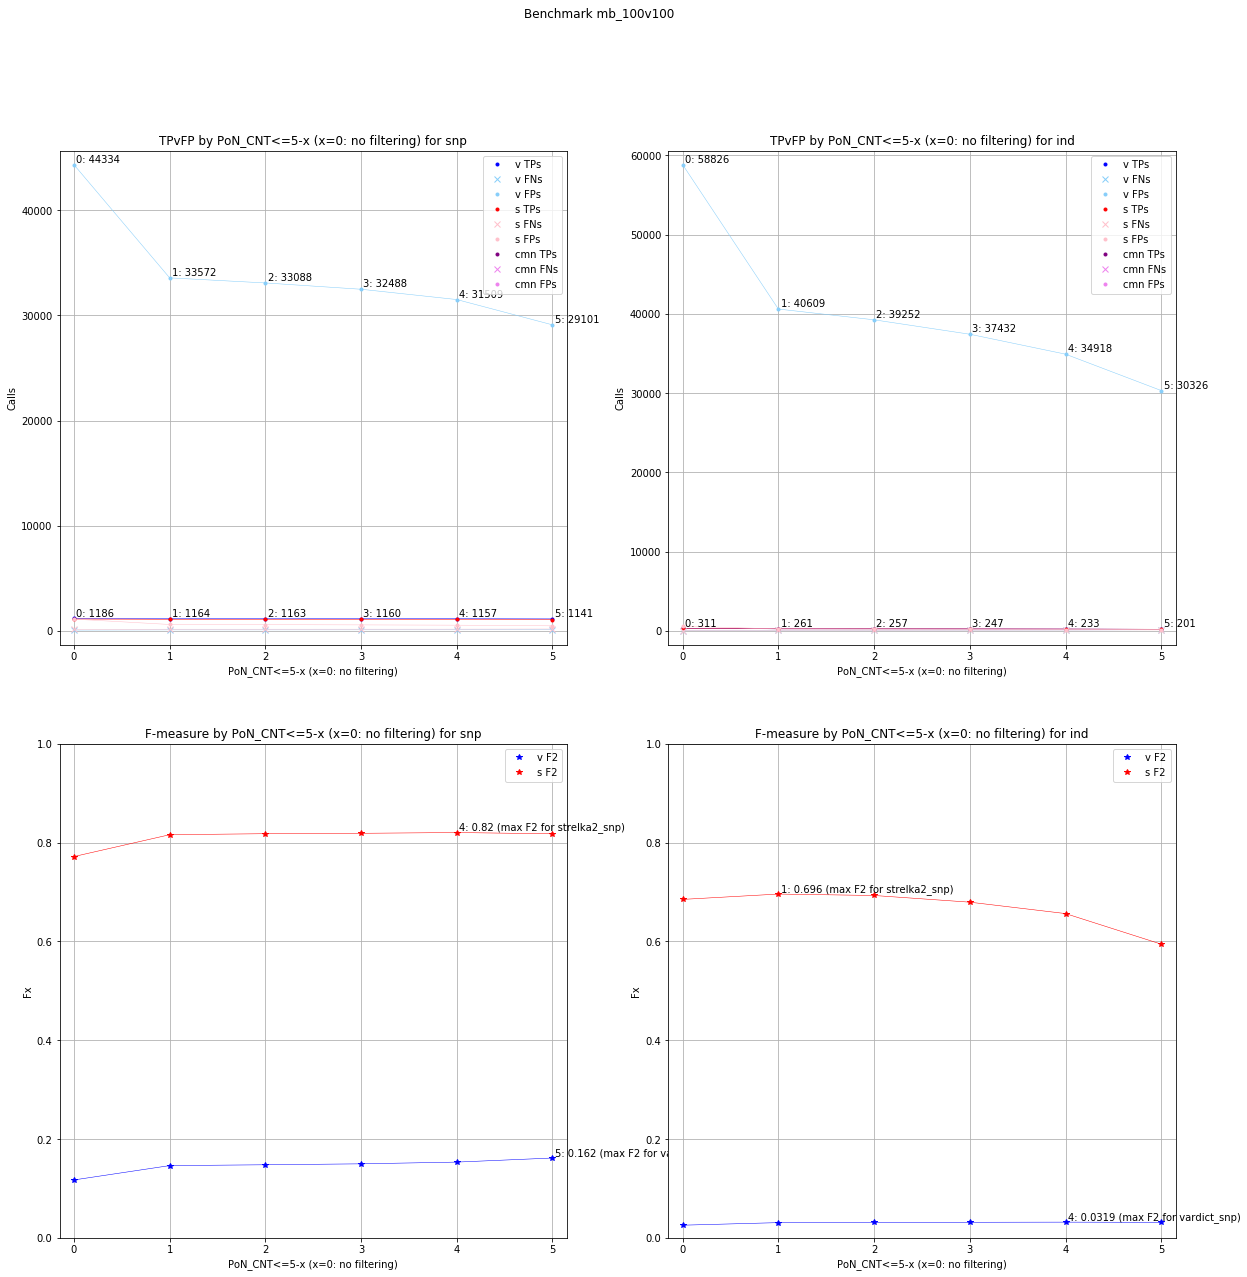

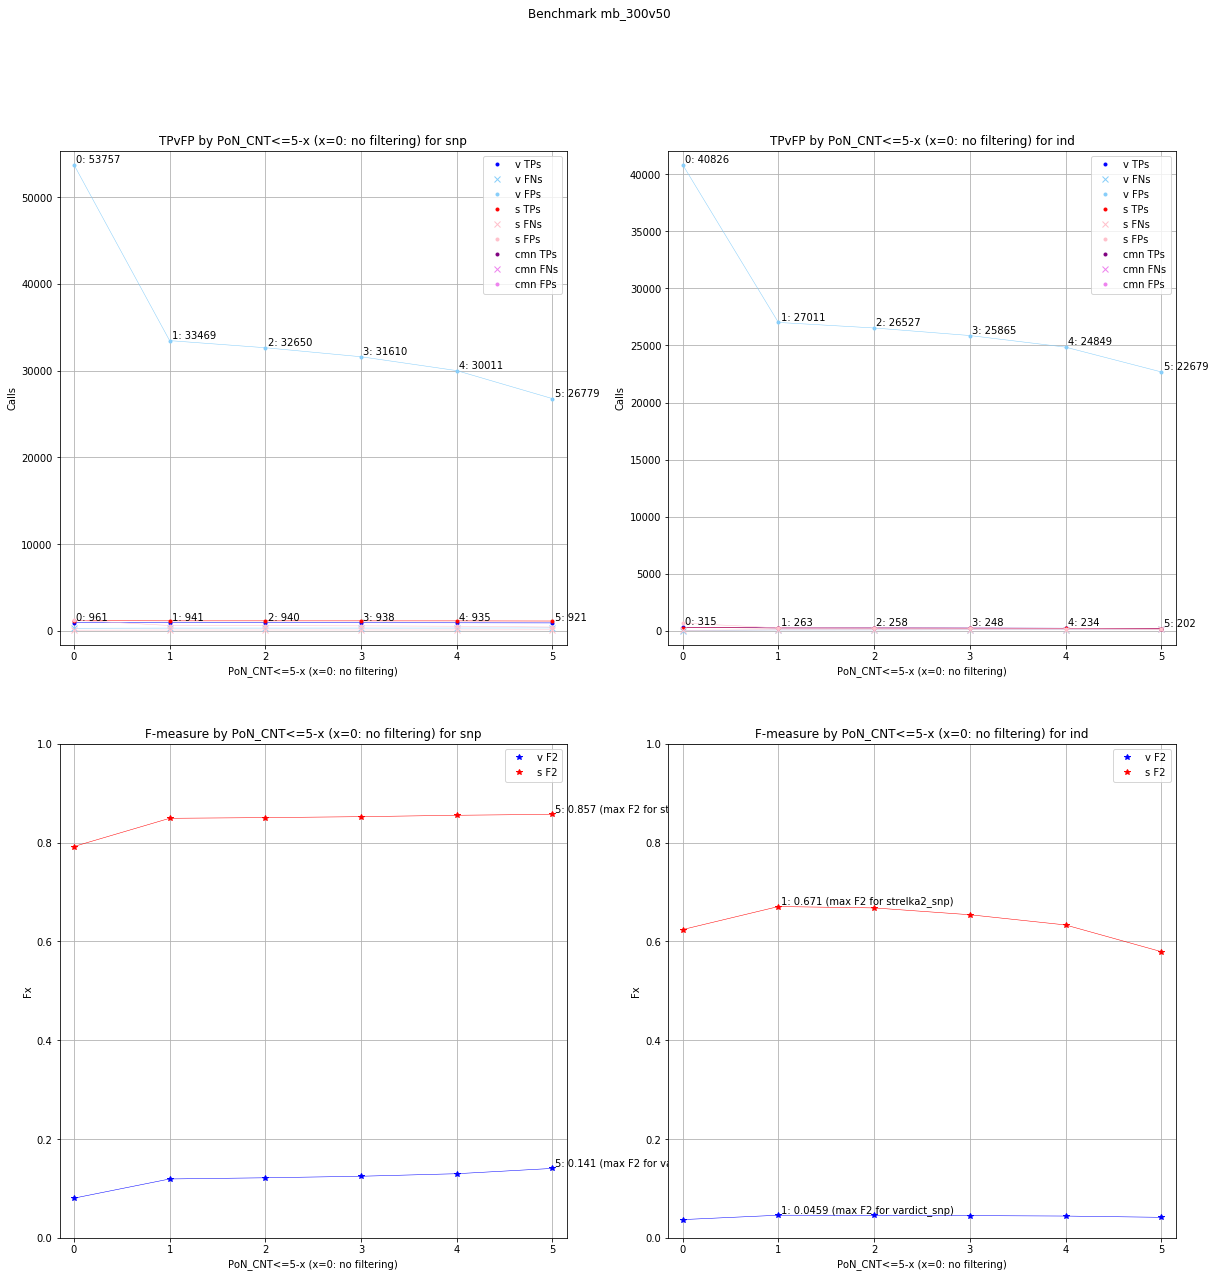

In [206]:
MAX_PON=5
    
def get_pon(v):
    pon_cnt = v['PoN_CNT']
    if np.isnan(pon_cnt): pon_cnt = math.inf

    pon_level = MAX_PON  # we want pon_level be the-more-the-better
    for n in range(MAX_PON):
        if pon_cnt == n:  # PoN_CNT=0 is the best quality, so it translates into the highest value MAX_PON-0
            return MAX_PON-n
    return 0  # if PoN_CNT is as high as MAX_PON, we always return the lowest value 0

#PoN_CNT=0  Pon_CNT<=0  pon_level=5-0 = 5
#PoN_CNT=1  Pon_CNT<=1  pon_level=5-1 = 4
#PoN_CNT=4  Pon_CNT<=4  pon_level=5-4 = 1
#PoN_CNT>=5             pon_level=MAX_PON = 5
def filt(v):  # VarDict is getting better than strelka after this filtering!
    return get_vd_af_qual(v) < 40
    
plot_roc('mb_100v100', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1,
    label_step=1, field_fn=get_pon, filt_fn=filt)
plot_roc('mb_300v50', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1,
    label_step=1, field_fn=get_pon, filt_fn=filt)

plot_roc('colo_40pc_ds', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1,
    label_step=1, field_fn=get_pon, filt_fn=filt)
plot_roc('colo_40pc_full', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1,
    label_step=1, field_fn=get_pon, filt_fn=filt)
plot_roc('colo_tgen', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1,
    label_step=1, field_fn=get_pon, filt_fn=filt)
pass

Plotting colo_40pc_ds


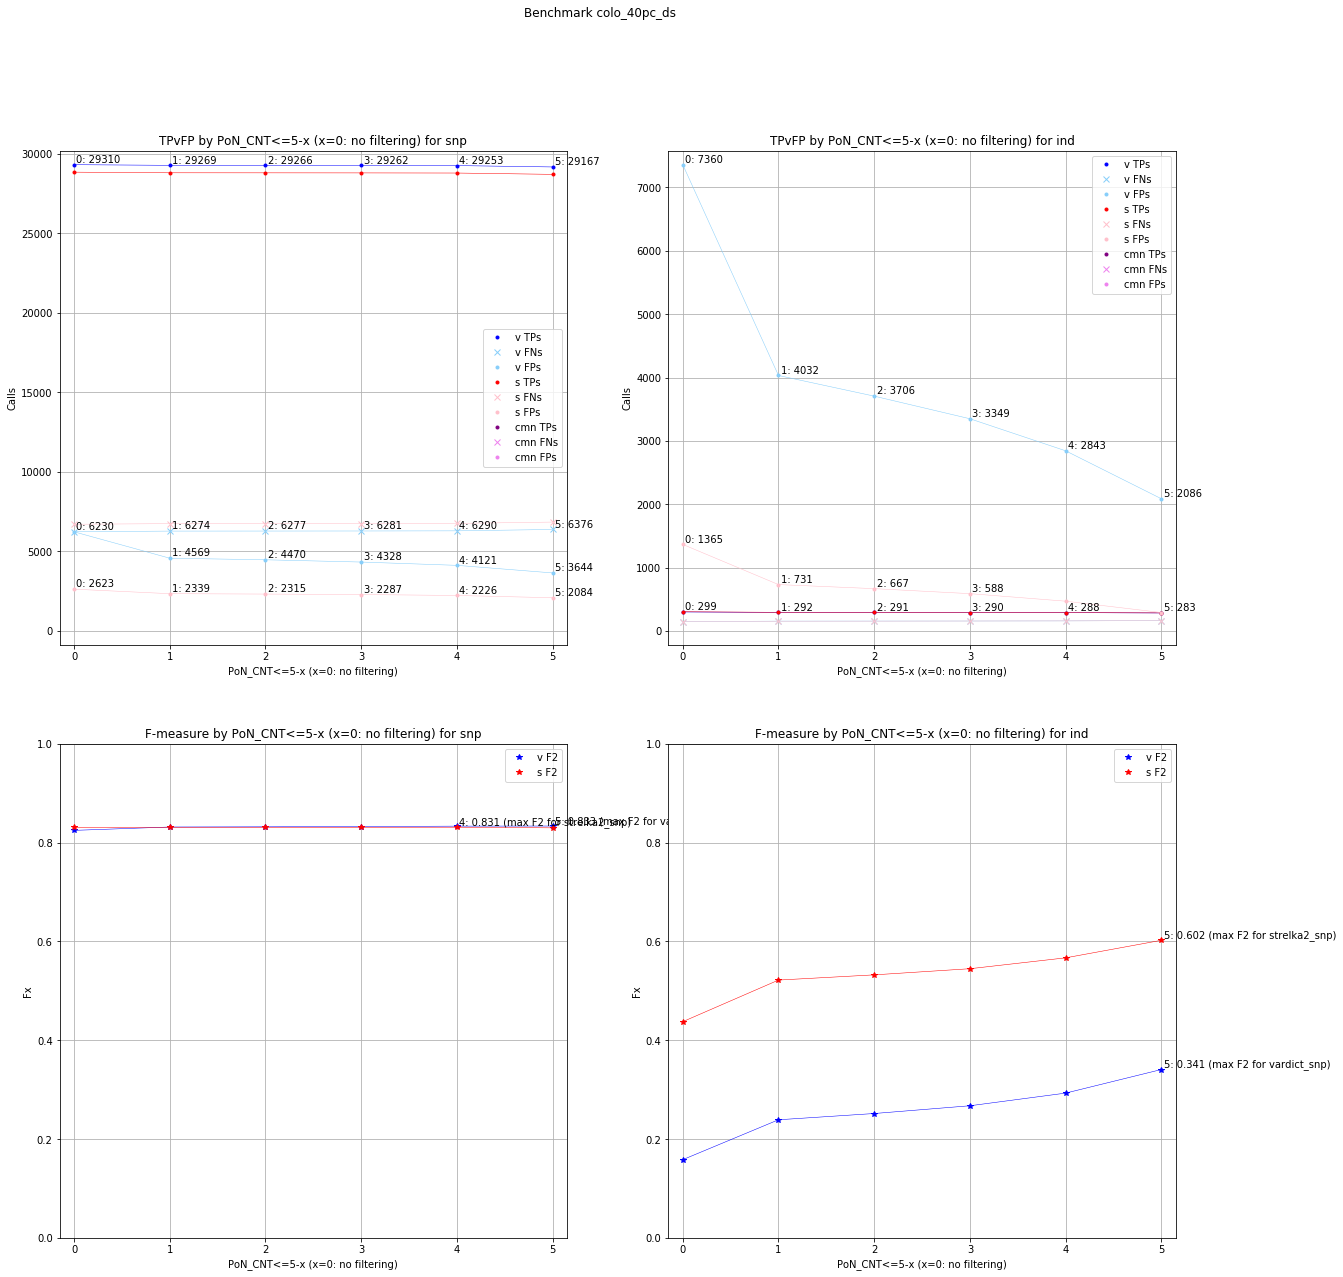

In [208]:
plot_roc('colo_40pc_ds', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, 
    step=1, label_step=1, field_fn=get_pon)
pass

Plotting colo_40pc_full


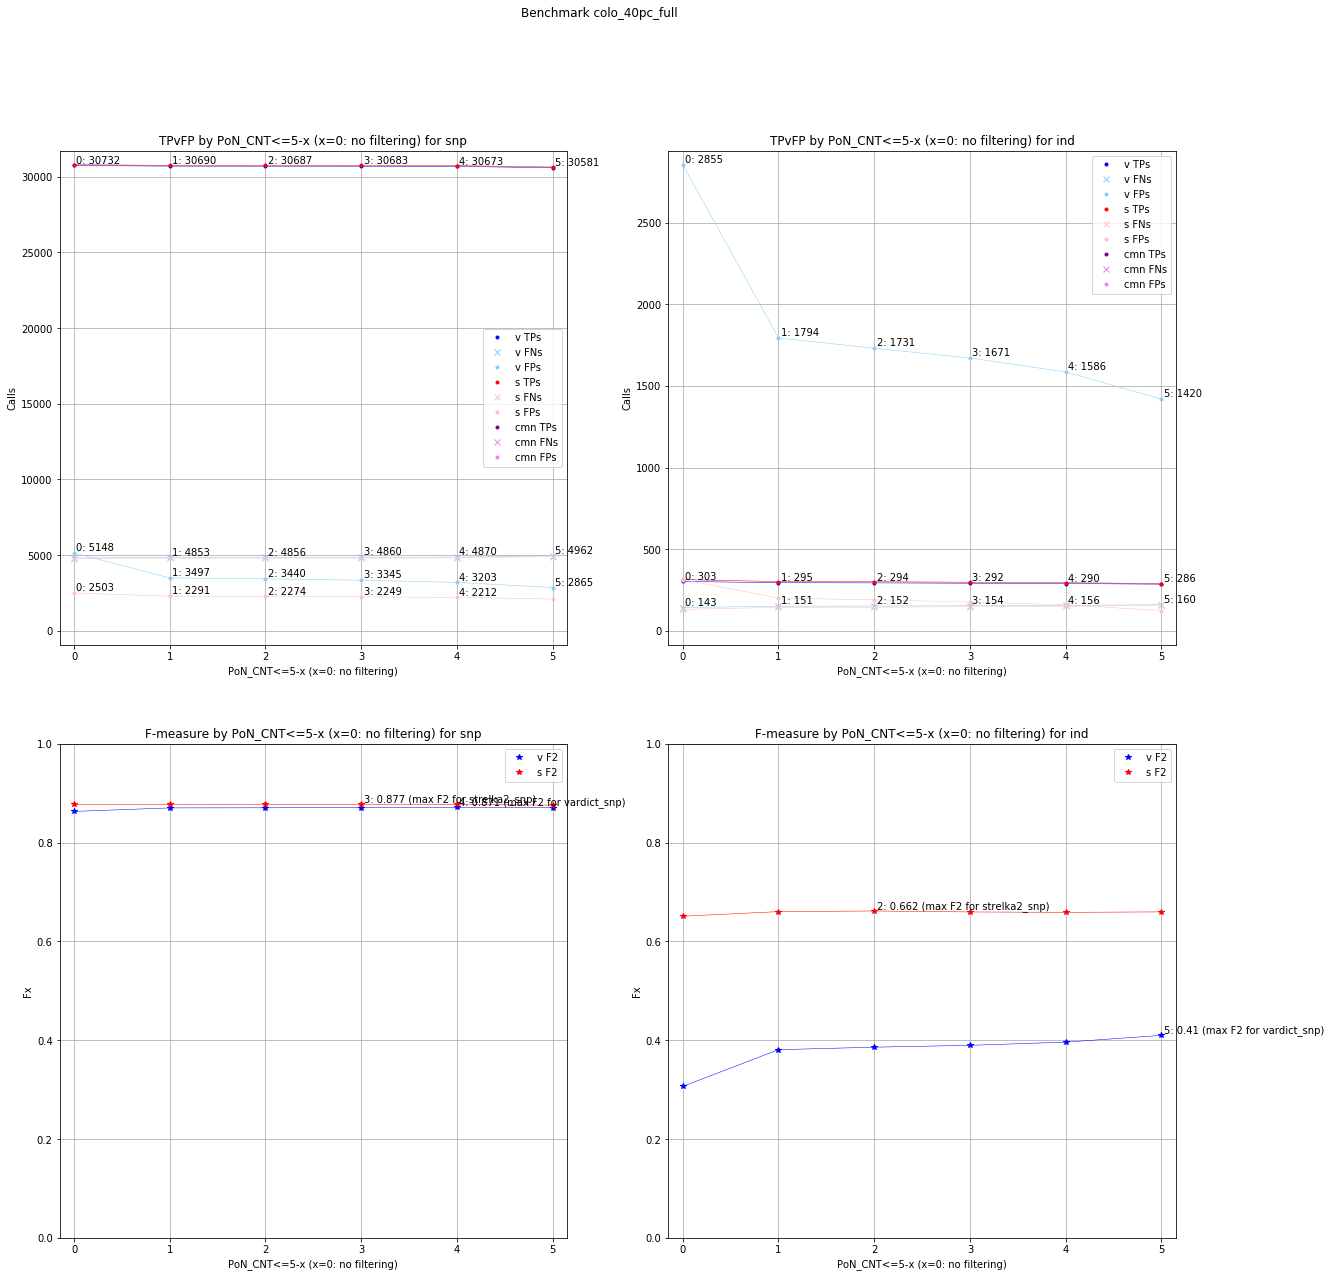

In [211]:
plot_roc('colo_40pc_full', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1, 
    label_step=1, field_fn=get_pon)
pass

Plotting colo_tgen


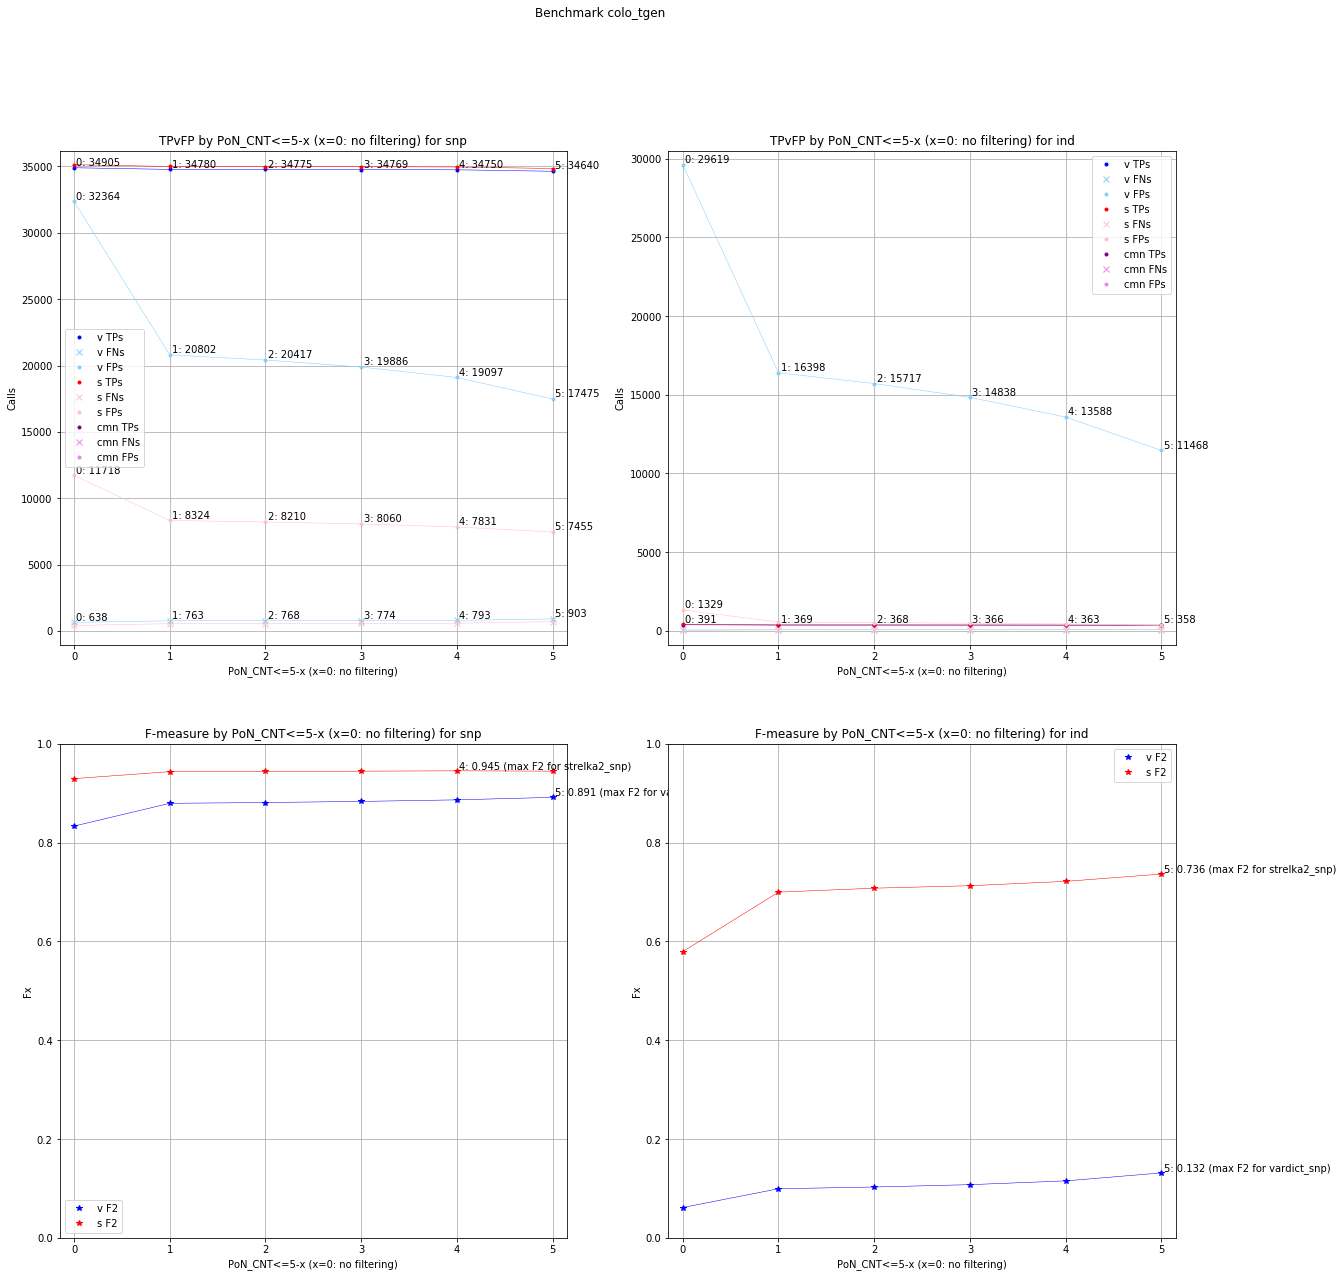

In [210]:
plot_roc('colo_tgen', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1, 
    label_step=1, field_fn=get_pon)
pass

In [4]:
def roc_points(bn, df, f, start=None, end=None, step=None, label_step=None):
    print(f'Calc roc points for {bn} {f}')
    bdf = df.loc[bn]

    start = start or min(bdf[f])
    end = end or max(bdf[f])
    step = step or (0.01 if (end-start)/10<1 else 1)
    label_step = step * 10
    print(f'  calculating for {f} thresholds from {start} to {end} with step of {step}')

    tps, fps, precs, recalls = [], [], [], []

    vals = np.arange(start, end + step, step)
    for val in vals:
        val_df = bdf[bdf[f] >= val]
        tp = len(val_df[val_df['typ'] == 'tp'])
        fn = len(val_df[val_df['typ'] == 'fn'])
        fp = len(val_df[val_df['typ'] == 'fp'])

        tps.append(tp)
        fps.append(fp)
        called = tp + fp
        precs.append(tp / called if called else 0)
        truth = tp + fn
        recalls.append(tp / truth if truth else 0)

#         # Labels
#         for v, tp, fp in zip(vals, tps, fps):
#             label = f'{v}'
#             if v % label_step == 0:  #and k == l and v == lfs[0][0]:
#                 print('Annotating')
#                 roc_ax.annotate(f'{label}: {fp}, {tp}', xy=(fp, tp))
#                 tp_fp_ax.annotate(f'{label}: {tp}', xy=(v, tp))
#                 tp_fp_ax.annotate(f'{label}: {fp}', xy=(v, fp))
#         plt.grid()
    return vals, tps, fps, label_step
    
roc_pts_by_f_by_bn = defaultdict(dict)
for bn in benchmarks_names:
    roc_pts_by_f_by_bn[bn]['TUMOR_AF'] = roc_points(bn, data, 'TUMOR_AF')
    roc_pts_by_f_by_bn[bn]['TUMOR_DP'] = roc_points(bn, data, 'TUMOR_DP', end=500)
    roc_pts_by_f_by_bn[bn]['TUMOR_MQ'] = roc_points(bn, data, 'TUMOR_MQ')

Calc roc points for mb TUMOR_AF
  calculating for TUMOR_AF thresholds from 0.03424660116434097 to 1.0735299587249756 with step of 0.01
Calc roc points for mb TUMOR_DP
  calculating for TUMOR_DP thresholds from 6.0 to 333.0 with step of 1
Calc roc points for mb TUMOR_MQ
  calculating for TUMOR_MQ thresholds from 18.399999618530273 to 60.0 with step of 1
Calc roc points for colo TUMOR_AF
  calculating for TUMOR_AF thresholds from 0.011774499900639057 to 1.0 with step of 0.01
Calc roc points for colo TUMOR_DP
  calculating for TUMOR_DP thresholds from 2.0 to 7409.0 with step of 1
Calc roc points for colo TUMOR_MQ
  calculating for TUMOR_MQ thresholds from 13.75 to 60.0 with step of 1


In [22]:
roc_pts_by_f_by_bn['colo']['TUMOR_AF'][1][50], \
roc_pts_by_f_by_bn['colo']['TUMOR_DP'][1][50], \
roc_pts_by_f_by_bn['colo']['TUMOR_MQ'][1][50]

(19955, 19955, 19955)

In [105]:
# Defining function for plotting ROC and TP/FP ratios curves

from matplotlib import gridspec
from matplotlib.transforms import blended_transform_factory
from ipywidgets import *

tp_colors = ['blue', 'red', 'green']
fp_colors = ['lightblue', 'pink', 'lightgreen']

def plot_roc_2(roc_pts_by_f_by_bn):
    for j, (bn, roc_pts_by_f) in enumerate(roc_pts_by_f_by_bn.items()):
#        print(f'Plotting {bn}')

        fig = plt.figure(figsize=(20, 10*(1+len(roc_pts_by_f))//2))
        grid = gridspec.GridSpec(2, (1+len(roc_pts_by_f))//2)
        plt.suptitle(f'Benchmark {bn}')
        
        roc_ax = plt.subplot(grid[0], label=f'ROC', title=f'ROC curve')
        roc_ax.set_xlabel('TPR')
        roc_ax.set_ylabel('FPR')

        for i, (f, [vals, tps, fps, label_step]) in enumerate(roc_pts_by_f.items()):
 #           print(f'   Plotting {f}')
            # ROC curve plot
            roc_ax.plot(tps, fps, '-', c=tp_colors[i], lw=0.5)
            roc_ax.plot(tps, fps, '.', c=tp_colors[i], label=f'{f}')
            plt.grid()
            
            # TP/FP plot
            tp_fp_ax = plt.subplot(grid[1+i], label=f'TP v FP', title=f'TP v FP curve by {f}')
            tp_fp_ax.set_xlabel(f'{f}')
            tp_fp_ax.set_ylabel('Calls')

            tp_fp_ax.plot(vals, tps, '-', c=tp_colors[i], lw=0.5)
            tp_fp_ax.plot(vals, tps, '.', c=tp_colors[i], label=f'{f} TPs')
            tp_fp_ax.plot(vals, fps, '-', c=fp_colors[i], lw=0.5)
            tp_fp_ax.plot(vals, fps, '.', c=fp_colors[i], label=f'{f} FPs')
            plt.grid()
    
#            max_tp_f = max(tps)
#            max_fp_f = max(fps)

#            delta = (end - start) * 0.05
#            tp_fp_ax.set_xlim([fd['start']-delta, fd['end']+delta])

#            max_y = max(max_tp_f, max_fp_f)
#            delta = max_y*0.05
#            tp_fp_ax.set_ylim([-delta, max_y+delta])
#            print(f'   Setting legend TP-FP {f}')
            tp_fp_ax.legend(*tp_fp_ax.get_legend_handles_labels(), loc=1)
            plt.grid()

            # Labels
#            print(f'   Annotating {f}')
            for v, tp, fp in zip(vals, tps, fps):
                label = f'{v}'
                if v % label_step == 0:  #and k == l and v == lfs[0][0]:
                    roc_ax.annotate(f'{label}: {fp}, {tp}', xy=(tp, fp))
                    tp_fp_ax.annotate(f'{label}: {tp}', xy=(v, tp))
                    tp_fp_ax.annotate(f'{label}: {fp}', xy=(v, fp))
            plt.grid()
        
        # ROC curve limits
 #       max_tp = max(max(vs) for vs in tps_by_f.values())
 #       max_fp = max(max(vs) for vs in fps_by_f.values())

 #       delta = max_tp*0.05
 #       roc_ax.set_xlim([0, max_tp+delta])

 #       delta = max_fp*0.05
 #       roc_ax.set_ylim([0, max_fp+delta])

 #       print(f'   Setting legend ROC')
        roc_ax.legend(*roc_ax.get_legend_handles_labels(), loc=2)
        plt.grid()

def _plot(af, dp, mq):
    min_by_f = {
        'TUMOR_AF': af,
        'TUMOR_DP': dp,
        'TUMOR_MQ': mq,
    }
    r = defaultdict(dict)
    for bn, roc_pts_by_f in roc_pts_by_f_by_bn.items():
        for f, (vals, tps, fps, label_step) in roc_pts_by_f.items():
            triplets = [(v, tp, fp) for (v, tp, fp) in zip(vals, tps, fps) if v >= min_by_f[f]]
            vals, tps, fps = zip(*triplets)
            r[bn][f] = vals, tps, fps, label_step

    plot_roc_2(r)

interact(_plot, af=0.01, dp=10, mq=20)

A Jupyter Widget

<function __main__._plot>

# Venn

In [213]:
# Counting statistics on per-chromosome basis: unique to BWA vs. unqiue to minimap2 vs. 
# common calls. Drawing summary Venn diagrams for each caller and aligner:
# 
# mm2/bwa ensemble    tp-snp  tp-ind  fp-snp  fp-ind  fn-snp  fn-ind 
# mm2/bwa strelka2    --//--  --//--
# mm2/bwa mutect2     --//--
# mm2/bwa vardict
# v/s/m bwa  
# v/s/m mm2            

from matplotlib_venn import venn2, venn3
from matplotlib import gridspec
import itertools
import math

criteria_name = 'PoN_CNT'
rows_criterias = [1, 2, 3, math.inf]
criteria_op = '<'

def plot_venn(bn, df=None):
    b = benchmark_d[bn]
    df = df if (df is not None) else benchmark_d[bn]['df']

    validation_types = ['tp', 'fp', 'fn']
    event_types = [True, False]  # SNP, non-SNP

    rows_cnt = len(rows_criterias)
    figsize = (18, 3.6*rows_cnt)
    fig = plt.figure(figsize=figsize)
    outer = gridspec.GridSpec(1 + rows_cnt, 
                              1 + len(event_types),
                              height_ratios=[1] + [7]*rows_cnt,
                              width_ratios=[1] + [2*len(validation_types)] * len(event_types))
                              
    def left_col_label(txt, ax):
        plt.text(0, 0.5, txt,
            fontsize=16,
            horizontalalignment='left',
            verticalalignment='center')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)     
        plt.axis('off')
            
    # HEADER
    for is_snp_i, is_snp in enumerate(event_types):
        inner = gridspec.GridSpecFromSubplotSpec(1, len(validation_types), 
                                                 subplot_spec=outer[0, 1 + is_snp_i])
        lbl = 'SNP' if is_snp else 'Indel'
        for typ_i, typ in enumerate(validation_types):
            ax = plt.subplot(inner[typ_i])
            plt.text(0.5, -0.5, f'{lbl}, {typ}',
                fontsize=14,
                horizontalalignment='center',
                verticalalignment='bottom',
            )
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)     
            plt.axis('off')

    # 2-way L vs R, one raw for a criteria
    for criteria_i, criteria in enumerate(rows_criterias):
        ax = plt.subplot(outer[1 + criteria_i, 0])
        left_col_label(f'{criteria_name}{criteria_op}{criteria}' if criteria is not None else '', ax)

        for is_snp_i, is_snp in enumerate(event_types):
            inner = gridspec.GridSpecFromSubplotSpec(1, len(validation_types), 
                             subplot_spec=outer[1 + criteria_i, 1 + is_snp_i])
            lbl = 'SNP' if is_snp else 'Indel'
            for typ_i, typ in enumerate(validation_types):
#                dbg.set_trace()
                ax = plt.subplot(inner[typ_i])
                #sets = [set(df.query( & is_snp == {is_snp}').index.tolist())]          
                dff = df.query(f'is_snp == {is_snp}')
                if criteria: dff = dff.query(f'{criteria_name}{criteria_op}{criteria}')
                sets = [set(dff.query(f'{p}_typ == "{typ}"').index.tolist()) for p in [venn_left, venn_right]]    
                venn2(sets, set_labels=[l, r], ax=ax)

#     # 3-way Strelka2 vs Mutect vs VarDict, one raw for each aligner
#     clrs = [c for c in b['callers'] if c != 'ensemble']   
#     for aln_i, aln in enumerate(['bwa', 'mm2']):
#         ax = plt.subplot(outer[1 + len(b['callers']) + aln_i, 0])
#         left_col_label(aln, ax)
        
#         for is_snp_i, is_snp in enumerate(event_types):
#             inner = gridspec.GridSpecFromSubplotSpec(1, len(validation_types), 
#                              subplot_spec=outer[1 + len(b['callers']) + aln_i, 1 + is_snp_i])
#             lbl = 'SNP' if is_snp else 'Indel'
#             for typ_i, typ in enumerate(validation_types):
#                 ax = plt.subplot(inner[typ_i])
#                 sets = [set(df.query(f'{aln}_t == "{typ}" & caller == "{clr}" & is_snp == {is_snp}').index.tolist())
#                         for clr in clrs]                
#                 venn3(sets, set_labels=clrs, ax=ax)
                
plot_venn('mb_ds')
plot_venn('mb_300v50')
plot_venn('colo_40pc_ds')
plot_venn('colo_40pc_full')
plot_venn('colo_tgen')